In [1]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import lmfit
from scipy.io import readsav

In [86]:
%load_ext autoreload
%autoreload 2

from DSTPolarimeterLib import MuellerMatrixMirror, MuellerMatrixRotation
from DSTPolarimeterPlotLib import *
from script_to_run_on_kipsua import Main
from MMSP2Lib import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dtor = 0.017453292519943295

---

# MM_45

In [5]:
path = '/nwork/kouui/dstsp/data/calibration/save/mm45/m20170103_17511_MM.sav'
saveFile = readsav(path, verbose=True)

--------------------------------------------------
Date: Fri Jan 13 16:48:22 2017
User: kouui
Host: shachi.hida
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.0
--------------------------------------------------
Successfully read 10 records of which:
 - 1 are of type NOTICE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 6 are of type VARIABLE
--------------------------------------------------
Available variables:
 - mm [<class 'numpy.ndarray'>]
 - wl [<class 'numpy.ndarray'>]
 - o [<class 'numpy.recarray'>]
 - p [<class 'numpy.recarray'>]
 - c [<class 'numpy.recarray'>]
 - s [<class 'numpy.recarray'>]
--------------------------------------------------


In [8]:
saveFile['wl']

array([  198.922,   199.395,   199.868, ...,  1115.523,  1115.939,
        1116.355])

In [10]:
saveFile['mm'].shape

(2068, 4, 4)

In [20]:
print("start: {} nm, end: {} nm".format(wl[650],wl[2050]))

start: 500.253 nm, end: 1109.278 nm


In [490]:
np.argmin( abs(saveFile['wl']-860) )

1462

In [492]:
saveFile["mm"][1462,:,:] / saveFile["mm"][1462,0,0]

array([[ 1.        , -0.02789666, -0.00278582, -0.01912723],
       [-0.03455996,  0.98631785, -0.09857136, -0.00230055],
       [ 0.00451821, -0.09321724, -0.8493866 , -0.50052879],
       [-0.00378543,  0.01900469,  0.50651627, -0.8551463 ]])

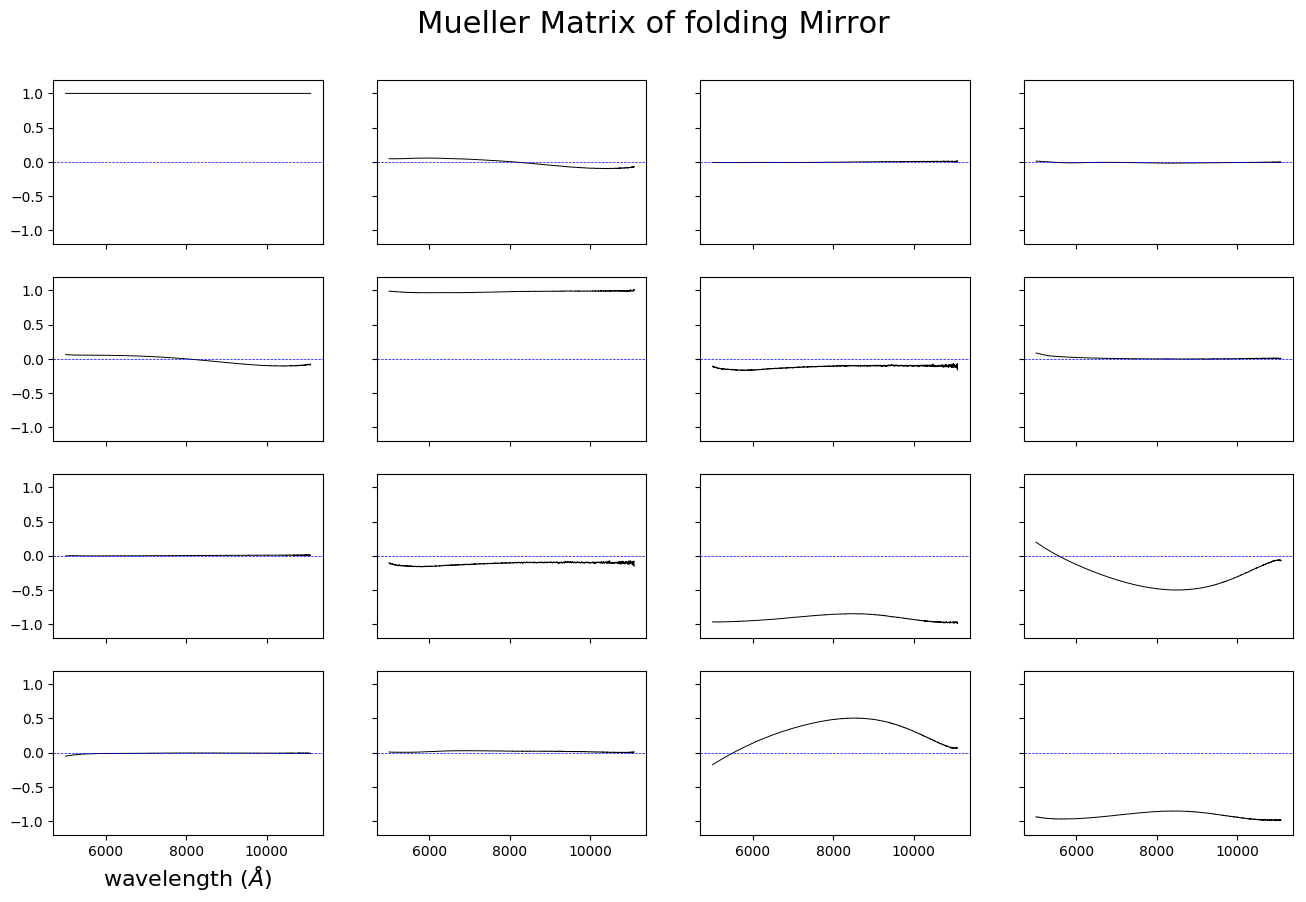

In [36]:
#
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=100, sharex=True, sharey=True)
mm = saveFile['mm']
wl = saveFile['wl']
x0, x1 = 650,2050


for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(wl[x0:x1]*10, mm[x0:x1,i,j]/mm[x0:x1,0,0], '-k', linewidth=0.7)
        ax.set_ylim(-1.2,1.2)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')

axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('Mueller Matrix of folding Mirror', x=0.5, y=0.95, fontsize=22);

## lowpass to denoise (not so good)

[https://algorithm.joho.info/programming/python/numpy-ifft-lowpass-denoise/](https://algorithm.joho.info/programming/python/numpy-ifft-lowpass-denoise/)

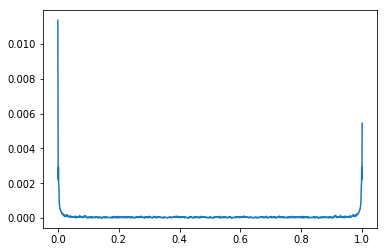

In [167]:
#
y_noise = mm[x0:x1,0,3]/mm[x0:x1,0,0]
N, dt = x1-x0, 1
# 周波数軸
freq = np.linspace(0, 1.0/dt, N)
# 高速フーリエ変換（周波数信号に変換）
F = np.fft.fft(y_noise)
# 正規化 + 交流成分2倍
F = F/(N/2)
F[0] = F[0]/2
# 配列Fをコピー
F2 = F.copy()

plt.plot(freq, np.abs(F))

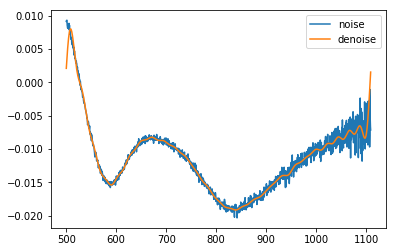

In [207]:
#
x = wl[x0:x1]
y_noise = mm[x0:x1,0,3]/mm[x0:x1,0,0]
N, dt = x1-x0, 1

# 周波数軸
freq = np.linspace(0, 1.0/dt, N)
# 高速フーリエ変換（周波数信号に変換）
F = np.fft.fft(y_noise)
# 正規化 + 交流成分2倍
F = F/(N/2)
F[0] = F[0]/2
# 配列Fをコピー
F2 = F.copy()

F2[(freq > 0.02)] = 0
y_denoise = np.fft.ifft(F2)
y_denoise = np.real(y_denoise*N)

plt.plot(x,y_noise, label="noise")
plt.plot(x,y_denoise, label="denoise")
plt.legend(loc="best");

## Savitzky-Golay filter to denoise (works well)

[http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html](http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html)

[https://stackoverflow.com/a/20642478](https://stackoverflow.com/a/20642478)

[https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html)

In [208]:
from scipy.signal import savgol_filter

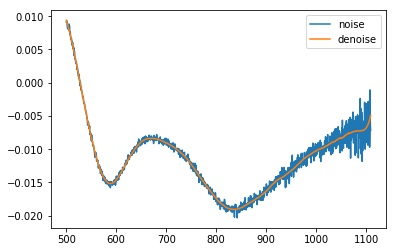

In [276]:
## do not apply this filter to a constant profile, ex, m00
x = wl[x0:x1]
y_noise = mm[x0:x1,0,3]/mm[x0:x1,0,0]
y_denoise = savgol_filter(y_noise, 201, 5)
plt.plot(x,y_noise, label="noise")
plt.plot(x,y_denoise, label="denoise")
plt.legend(loc="best");

## apply Savitzky-Golay filter to the whole mueller matrix

In [277]:
x0, x1 = 650,2050
N = x1-x0
mmFilter = np.ones((N,4,4))
wlFilter = saveFile['wl'][x0:x1].copy()

for i in range(4):
    for j in range(4):
        if i==0 and j==0:
            continue
        print("row: ",i,"col: ", j)
        temp = saveFile['mm'][x0:x1,i,j]/saveFile['mm'][x0:x1,0,0]
        mmFilter[:,i,j] = savgol_filter(temp, 201, 5)

row:  0 col:  1
row:  0 col:  2
row:  0 col:  3
row:  1 col:  0
row:  1 col:  1
row:  1 col:  2
row:  1 col:  3
row:  2 col:  0
row:  2 col:  1
row:  2 col:  2
row:  2 col:  3
row:  3 col:  0
row:  3 col:  1
row:  3 col:  2
row:  3 col:  3


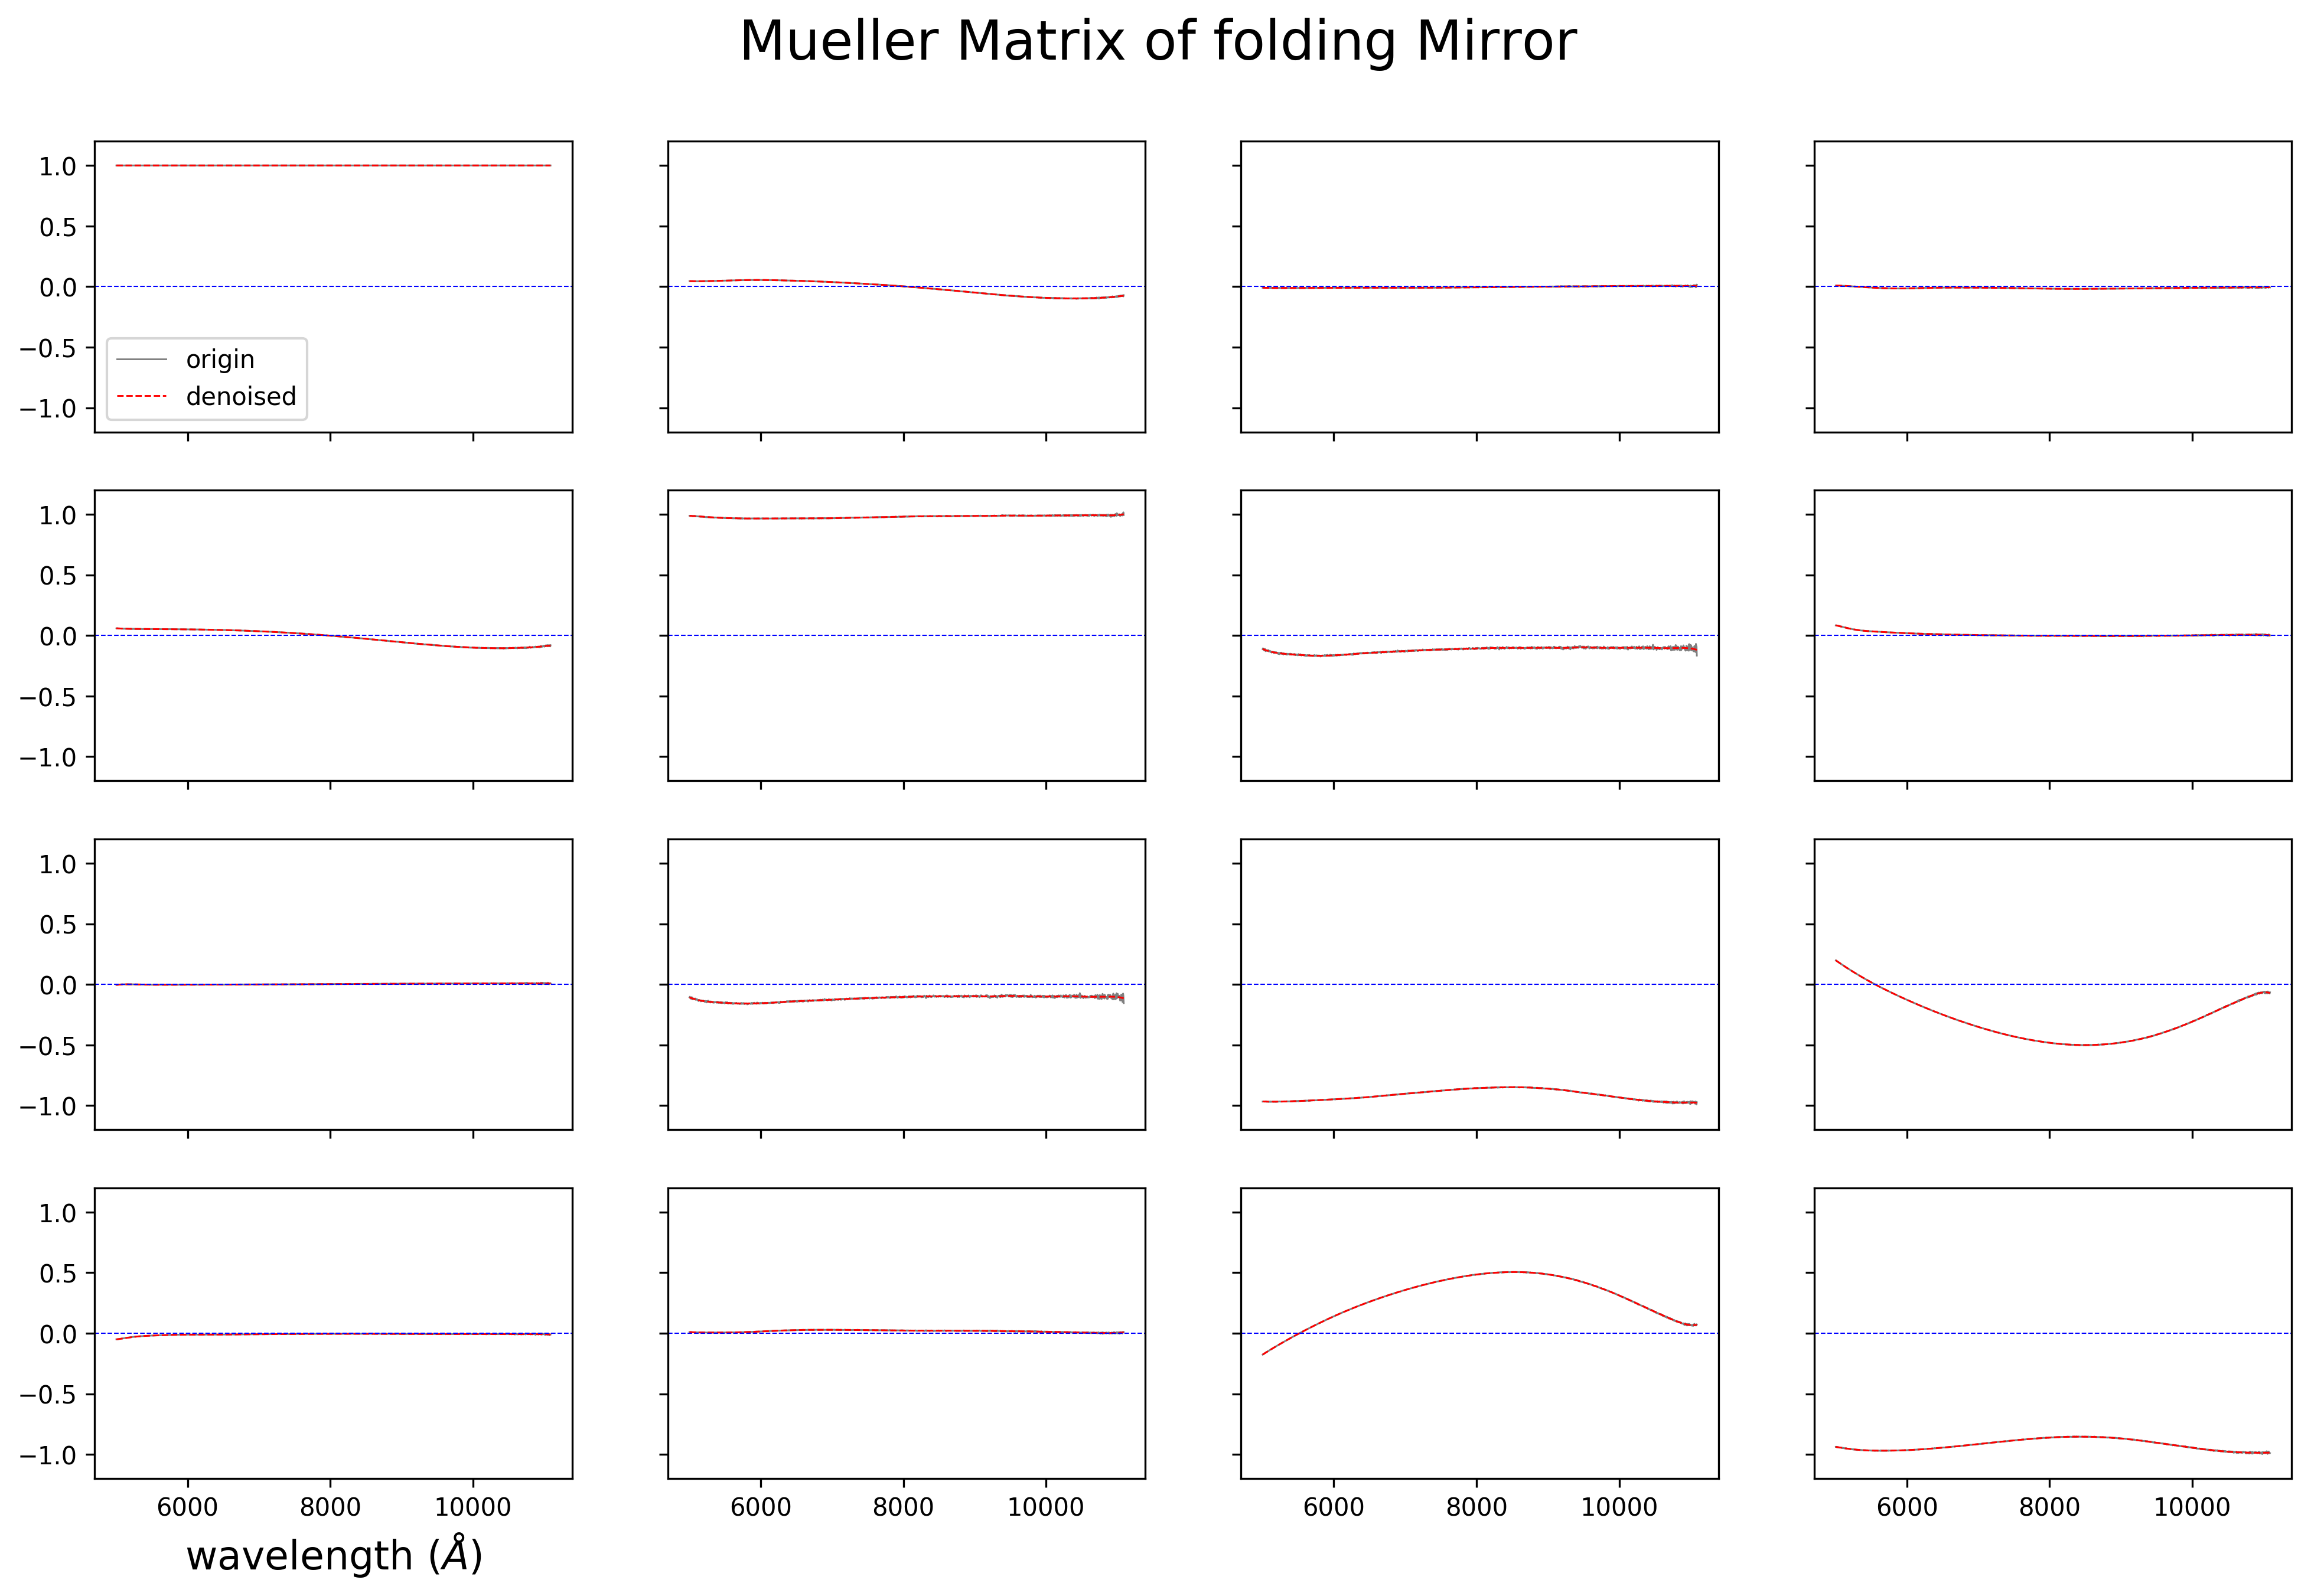

In [283]:
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=300, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(wl[x0:x1]*10, mm[x0:x1,i,j]/mm[x0:x1,0,0], '-k', linewidth=0.7, alpha=0.5, label="origin")
        ax.plot(wlFilter*10, mmFilter[:,i,j], '--r', linewidth=0.7, label="denoised")
        ax.set_ylim(-1.2,1.2)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')

axs[0,0].legend(loc='best')
axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('Mueller Matrix of folding Mirror', x=0.5, y=0.95, fontsize=22);

### check symmetry/anti-symmetry

mean deviation :  0.00506878256535


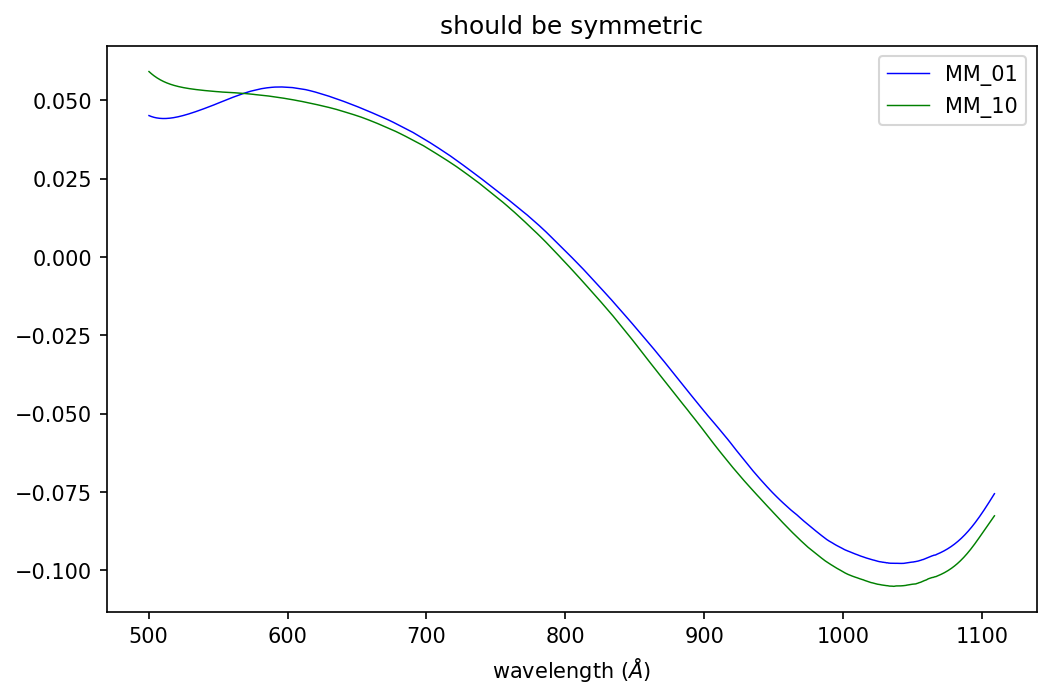

In [292]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 0, 1
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, mmFilter[:,c,r], '-g', linewidth=0.7, label="MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be symmetric")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]-mmFilter[:,c,r]).mean() )

$M_{01}$ and $M_{10}$ are fine

mean deviation :  0.0063838211


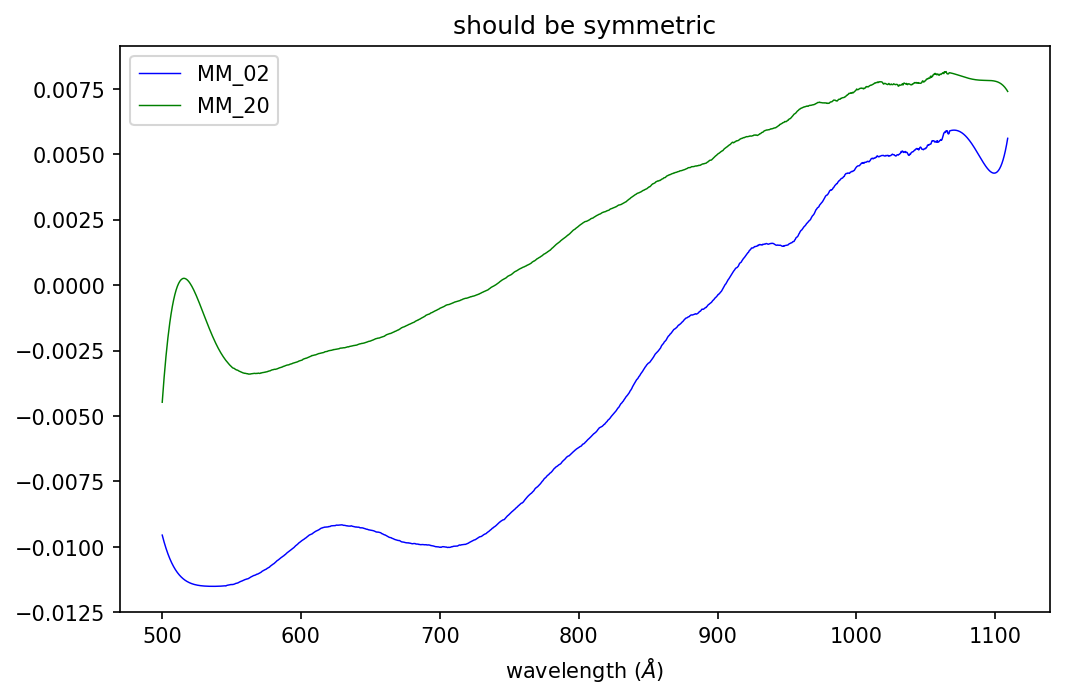

In [293]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 0, 2
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, mmFilter[:,c,r], '-g', linewidth=0.7, label="MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be symmetric")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]-mmFilter[:,c,r]).mean() )

$M_{02}$ and $M_{20}$ is not good, ignore them during fitting process?

mean deviation :  0.00756264254902


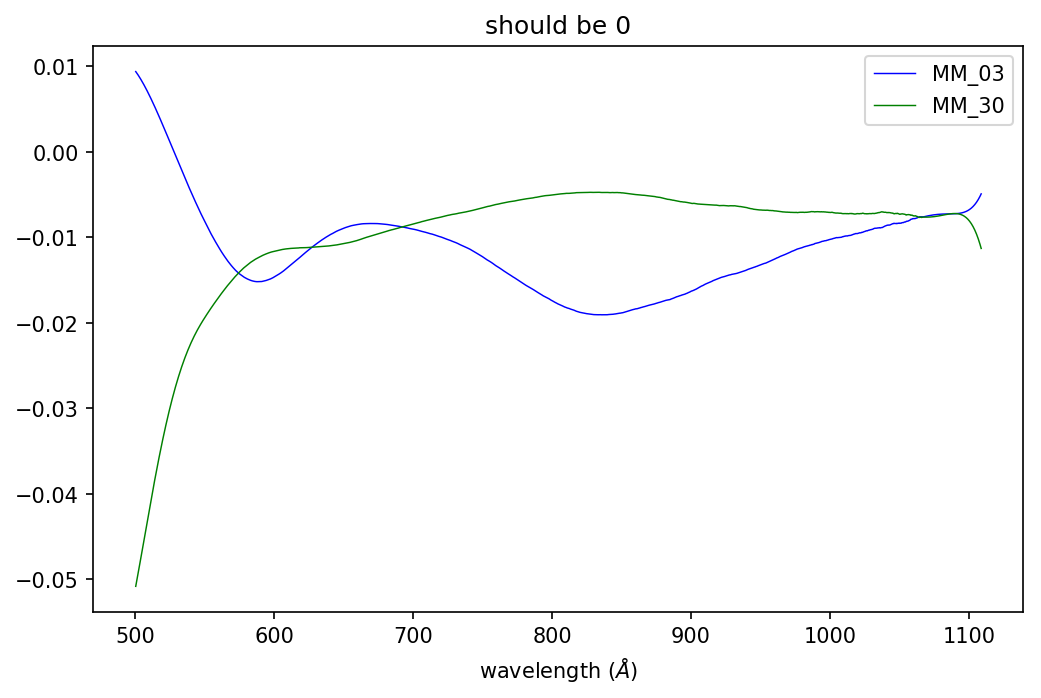

In [295]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 0, 3
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, mmFilter[:,c,r], '-g', linewidth=0.7, label="MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be 0")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]-mmFilter[:,c,r]).mean() )

what does this antiphase mean?

mean deviation :  0.0035887511451


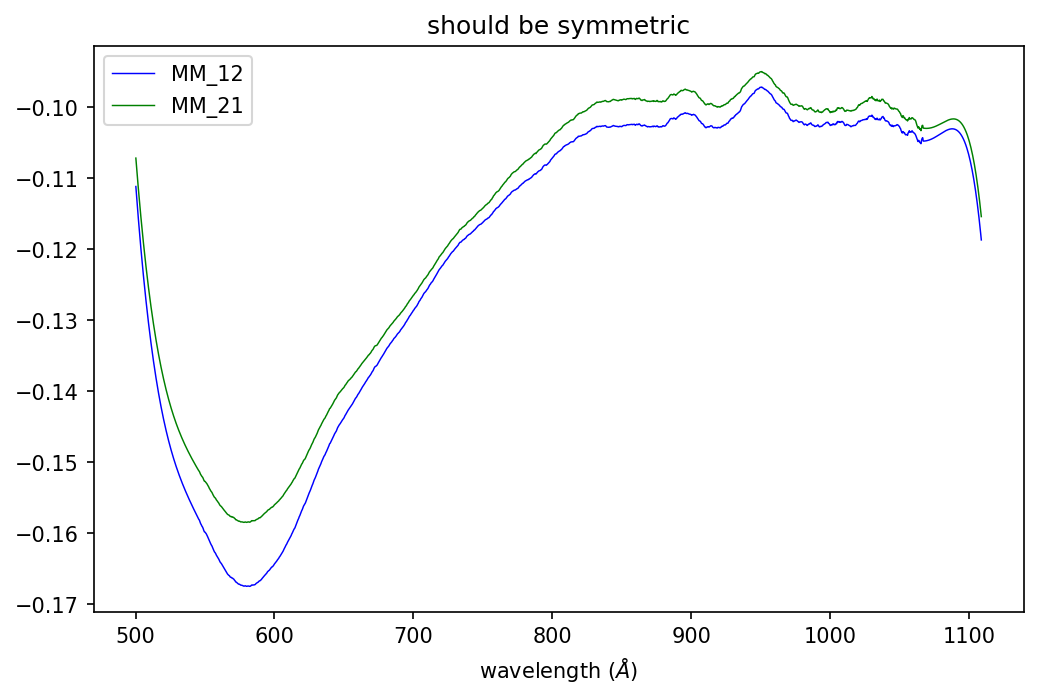

In [297]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 1, 2
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, mmFilter[:,c,r], '-g', linewidth=0.7, label="MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be symmetric")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]-mmFilter[:,c,r]).mean() )

the phase is quite good 

mean deviation :  0.0242433530462


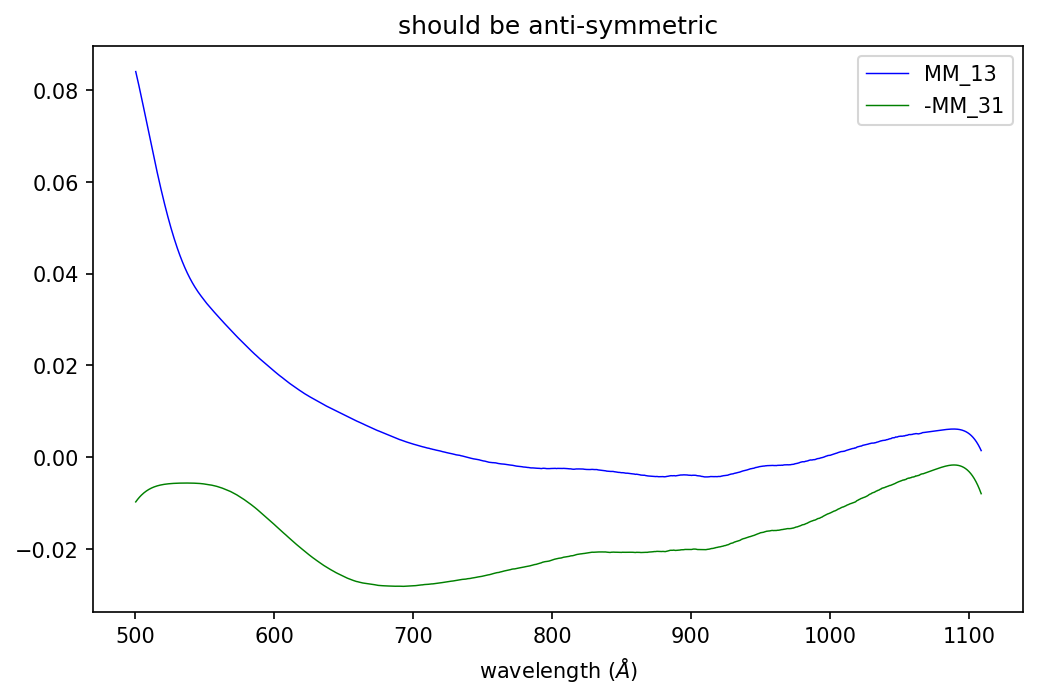

In [299]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 1, 3
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, -mmFilter[:,c,r], '-g', linewidth=0.7, label="-MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be anti-symmetric")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]+mmFilter[:,c,r]).mean() )

this is terrible

mean deviation :  0.00584030389654


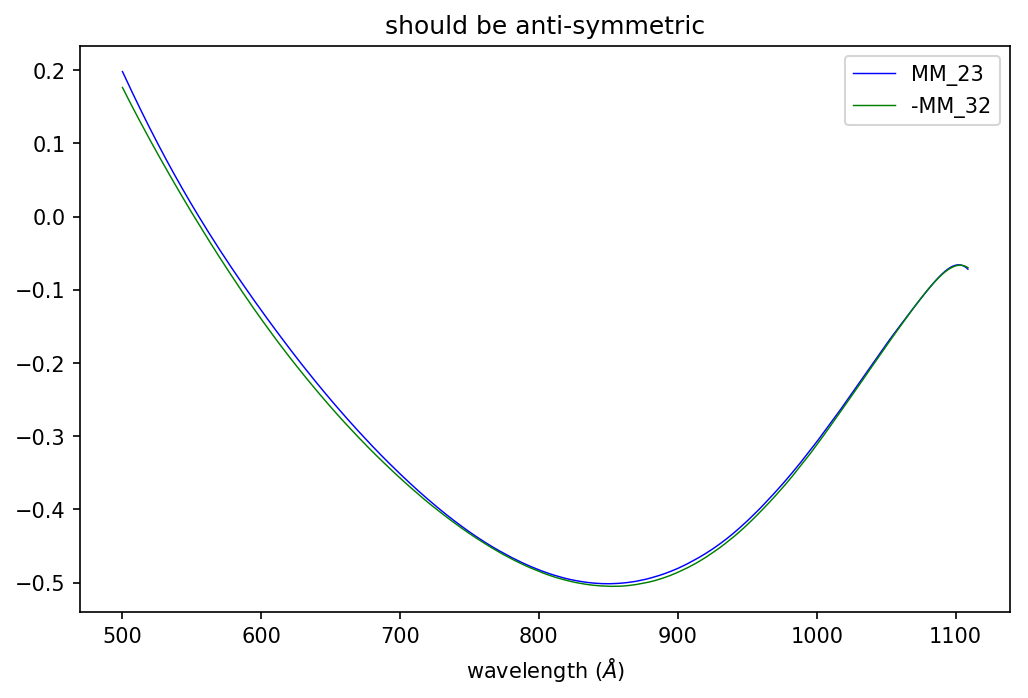

In [300]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 2, 3
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, -mmFilter[:,c,r], '-g', linewidth=0.7, label="-MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be anti-symmetric")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]+mmFilter[:,c,r]).mean() )

${mm}_{01}-{mm}_{10}$ and ${mm}_{02}-{mm}_{20}$

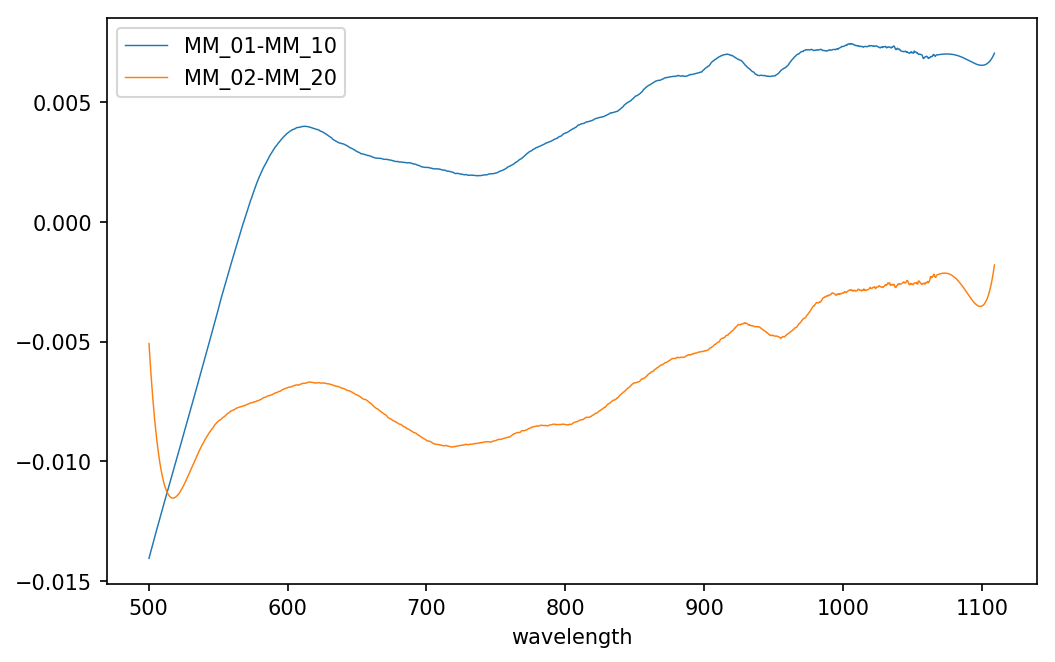

In [332]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 0, 1
ax.plot(wlFilter, mmFilter[:,r,c]-mmFilter[:,c,r], '-', linewidth=0.7, label="MM_{}{}-MM_{}{}".format(r,c,c,r))
r, c = 0, 2
ax.plot(wlFilter, mmFilter[:,r,c]-mmFilter[:,c,r], '-', linewidth=0.7, label="MM_{}{}-MM_{}{}".format(r,c,c,r))
ax.set_xlabel("wavelength")
ax.legend(loc="best");

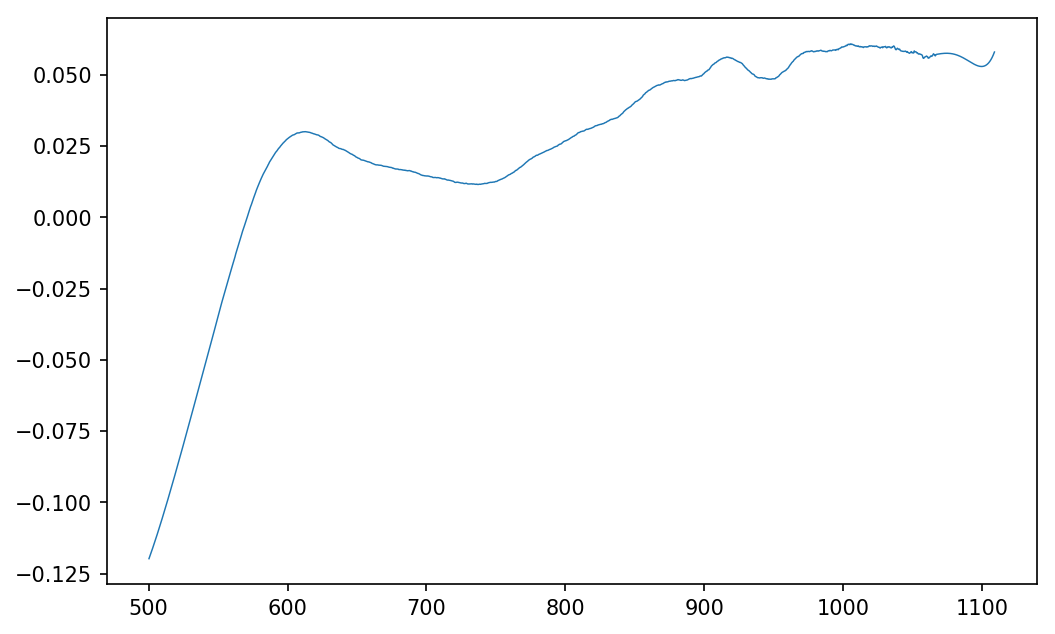

In [323]:
m01_m_m10 = ( (mmFilter[:,0,1]-mmFilter[:,1,0])*np.cos(2*0.03) + (mmFilter[:,0,2]-mmFilter[:,2,0])*np.sin(2*0.03)) / np.sin(4*0.03)
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
ax.plot(wlFilter, m01_m_m10, '-', linewidth=0.7);

whether ${mm}_{00}+{mm}_{33}$ = ${mm}_{11}+{mm}_{22}$

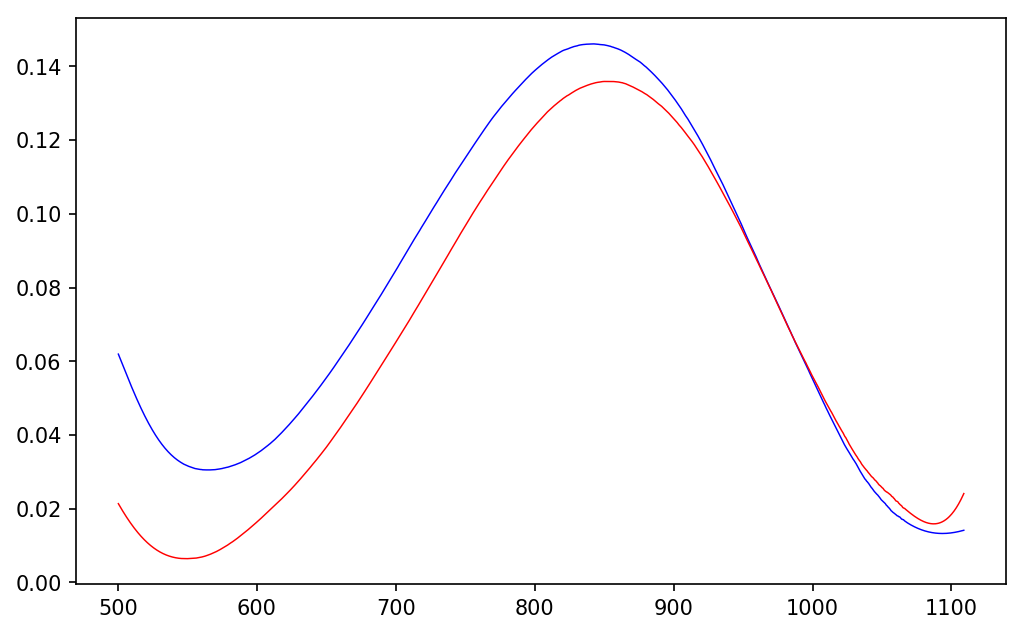

In [329]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
ax.plot(wlFilter, mmFilter[:,0,0] + mmFilter[:,3,3], '-b', linewidth=0.7);
ax.plot(wlFilter, mmFilter[:,1,1] + mmFilter[:,2,2], '-r', linewidth=0.7);

depolarization exist?

whether ${mm}_{12}-{mm}_{21}=0$ because  ${mm}_{12}-{mm}_{21}={m}_{12}-{m}_{21}$ do not depend on $\theta$, the symmetry will not change

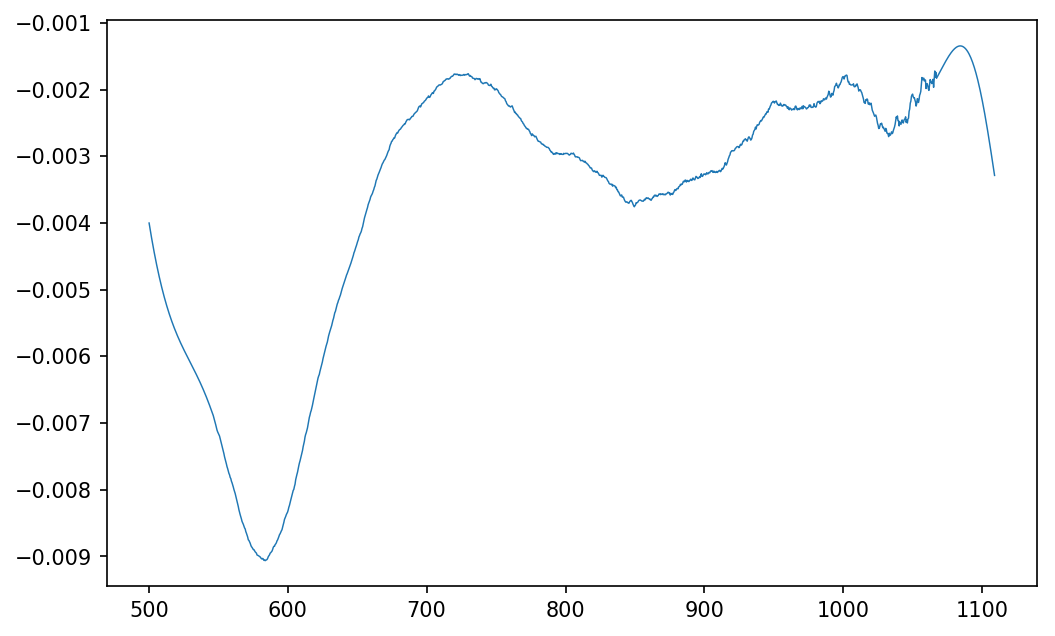

In [331]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
ax.plot(wlFilter, mmFilter[:,1,2] - mmFilter[:,2,1], '-', linewidth=0.7);
#ax.plot(wlFilter, mmFilter[:,1,1] + mmFilter[:,2,2], '-r', linewidth=0.7);

quite good beyond 7000A

${mm}_{13}+{mm}_{31}$ and ${mm}_{23}+{mm}_{32}$

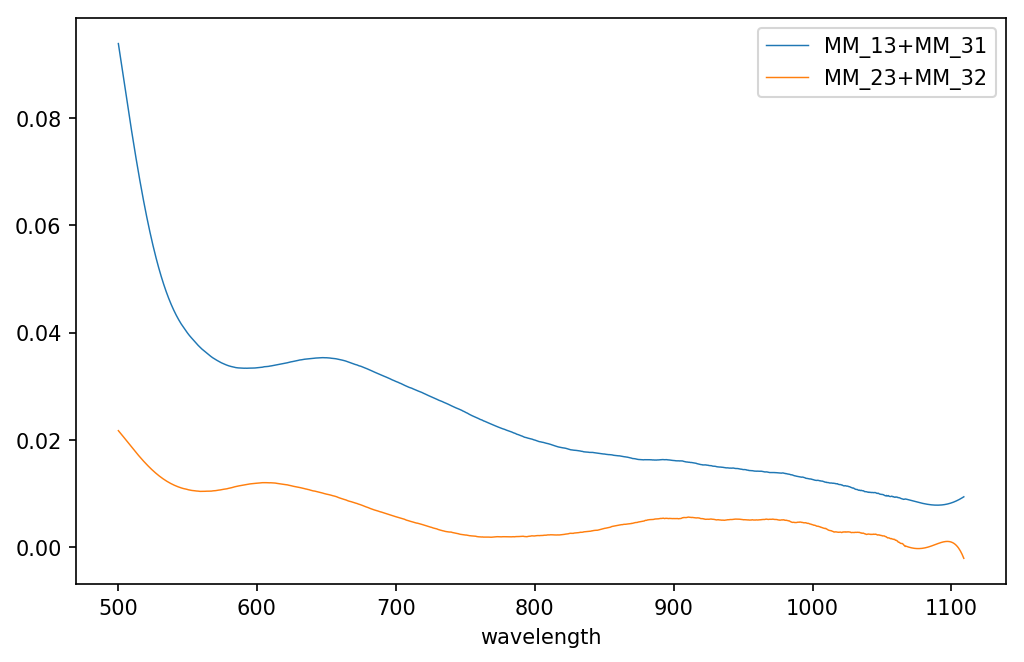

In [333]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 1, 3
ax.plot(wlFilter, mmFilter[:,r,c]+mmFilter[:,c,r], '-', linewidth=0.7, label="MM_{}{}+MM_{}{}".format(r,c,c,r))
r, c = 2, 3
ax.plot(wlFilter, mmFilter[:,r,c]+mmFilter[:,c,r], '-', linewidth=0.7, label="MM_{}{}+MM_{}{}".format(r,c,c,r))
ax.set_xlabel("wavelength")
ax.legend(loc="best");

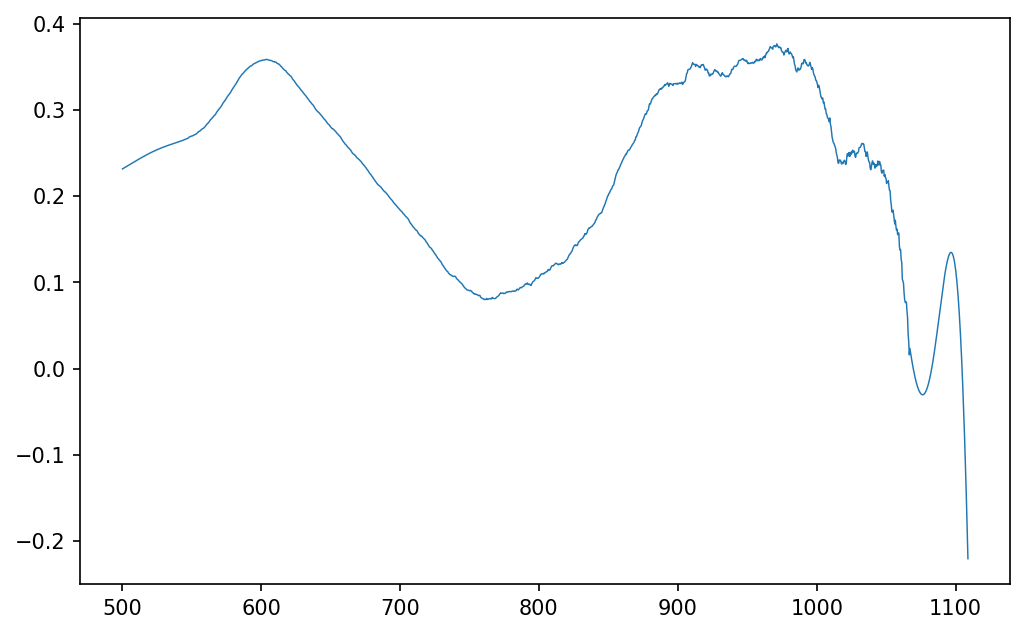

In [335]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 1, 3
temp1 = mmFilter[:,r,c]+mmFilter[:,c,r]
r, c = 2, 3
temp2 = mmFilter[:,r,c]+mmFilter[:,c,r]
ax.plot(wlFilter, temp2/temp1, '-', linewidth=0.7);

# fit mm_45 

### a try

In [88]:
def residual(par, y_data):
    
    y_model = model(par)
    
    return y_model.reshape(-1) - y_data.reshape(-1)

def model(par):
    
    theta = par["theta"]
    delta = par["delta"]
    p = par["p"]
    
    mm_mir = MuellerMatrixMirror(delta,p,gen=True)
    mat = MuellerMatrixRotation(-theta) @ (mm_mir/mm_mir[0,0]) @ MuellerMatrixRotation(theta)
    
    return mat


params = lmfit.Parameters()
params.add( "theta", value=0, min=-1., max=1. ,vary=True)
params.add( "p", value=0, min=-0.5, max=0.5, vary=True )
params.add( "delta", value=0, min=-np.pi, max=np.pi, vary=True )

In [91]:
mm.shape

In [116]:
for i in [1500]:#range(x0,x1):
    print("wavelength : {} $\AA$".format(wl[i]*10))
    y_data = mm[i,:,:] / mm[i,0,0]
    result = lmfit.minimize(residual, params, args=(y_data,), method='leastsq')

wavelength : 8762.84 $\AA$


In [117]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # function evals   = 19
    # data points      = 16
    # variables        = 3
    chi-square         = 0.001
    reduced chi-square = 0.000
    Akaike info crit   = -148.778
    Bayesian info crit = -146.460
[[Variables]]
    theta:  -0.02574888 +/- 0.001611 (6.26%) (init= 0)
    p:      -0.03905532 +/- 0.006217 (15.92%) (init= 0)
    delta:   0.52523836 +/- 0.006227 (1.19%) (init= 0)


In [118]:
print(result.residual.reshape(4,4))

[[ 0.         -0.00335748  0.00338224  0.01664422]
 [ 0.00296718  0.00918545  0.00430567 -0.02079489]
 [-0.00148386  0.00105761 -0.00696523 -0.00575129]
 [ 0.00558129  0.0053791  -0.00083806 -0.00414477]]


In [340]:
mm.shape

## fitting functions

In [341]:
np.deg2rad(5)

In [410]:
def fitMM45(y_data, isthetaConstant=False, isdepol=False, isQU=False, isretardC=False):
    
    assert isinstance(isthetaConstant,bool), "isthetaConstant must be a bool value"
    
    Nd = y_data.shape[0]
    
    #--- make parameter
    params = lmfit.Parameters()
    params.add( "theta0", value=0, min=-0.0873, max=0.0873 ,vary=True)
    #params.add( "theta_0", value=0, min=-0.0873, max=0.0873 ,vary=True)
    #for i in range(1,Nd):
    #    if not isthetaConstant:
    #        params.add( "theta_{}".format(i), value=0, min=-0.0873, max=0.0873 ,vary=True)
    #    else :
    #        params.add( "theta_{}".format(i), value=0, expr='theta_0')
    
    for i in range(Nd):
        params.add( "theta_{}".format(i), value=0, min=-0.0873, max=0.0873 ,vary=True)
    for i in range(Nd):
        params.add( "p_{}".format(i), value=0.05, min=-0.3, max=0.3 ,vary=True)
    for i in range(Nd):
        params.add( "delta_{}".format(i),value=0.3, min=-np.pi,max=np.pi,vary=True)
    for i in range(Nd):
        params.add( "depolarization_{}".format(i),value=0., min=-0.2,max=0.2,vary=isdepol)
    for i in range(Nd):
        params.add( "QU_{}".format(i),value=0., min=-0.2,max=0.2,vary=isQU)
    # for i in range(Nd):
    #     params.add( "IU_{}".format(i),value=0., min=-0.2,max=0.2,vary=True)
    for i in range(Nd):
        params.add( "retardConstant_{}".format(i),value=0., min=-0.2,max=0.2,vary=isretardC)
        
    result = lmfit.minimize(residual, params, args=(y_data,Nd,isthetaConstant), method='leastsq')
    
    return result

def residual(par, y_data, Nd, isthetaConstant):
    
    y_model = model(par, Nd, isthetaConstant)
    
    return y_model-y_data

def model(par, Nd, isthetaConstant):
    
    mat = np.ones((Nd,4,4))
    
    for i in range(Nd):
        mm_mir = MuellerMatrixMirror(par["delta_{}".format(i)].value,par["p_{}".format(i)].value,gen=True)
        mm_mir /= mm_mir[0,0]
        mm_mir[1,1] -= par["depolarization_{}".format(i)].value
        # mm_mir[0,2] += par["IU_{}".format(i)].value
        # mm_mir[2,0] += par["IU_{}".format(i)].value
        mm_mir[1,2] += par["QU_{}".format(i)].value
        mm_mir[2,1] += par["QU_{}".format(i)].value
        mm_mir[2,2] -= par["retardConstant_{}".format(i)].value
        mm_mir[2,3] -= par["retardConstant_{}".format(i)].value
        mm_mir[3,2] += par["retardConstant_{}".format(i)].value
        mm_mir[3,3] -= par["retardConstant_{}".format(i)].value
        if isthetaConstant:
            temp = MuellerMatrixRotation(-par["theta_{}".format(0)].value) @ mm_mir @ MuellerMatrixRotation(par["theta_{}".format(0)].value)
        else:
            temp = MuellerMatrixRotation(-par["theta_{}".format(i)].value) @ mm_mir @ MuellerMatrixRotation(par["theta_{}".format(i)].value)
        mat[i,:,:] = temp @ MuellerMatrixRotation(par["theta0"].value)
        
    return mat

def fittingResult2Array(result, Nd):
    
    theta0 = result.params["theta0"].value
    thetaArray = np.zeros(Nd)
    pArray = np.zeros(Nd)
    deltaArray = np.zeros(Nd)
    depolArray = np.zeros(Nd)
    QUArray = np.zeros(Nd)
    # IUArray = np.zeros(Nd)
    retardCArray = np.zeros(Nd)
    for i in range(Nd):
        thetaArray[i] = result.params["theta_{}".format(i)].value
        pArray[i] = result.params["p_{}".format(i)].value
        deltaArray[i] = result.params["delta_{}".format(i)].value
        depolArray[i] = result.params["depolarization_{}".format(i)].value
        QUArray[i] = result.params["QU_{}".format(i)].value
        # IUArray[i] = result.params["IU_{}".format(i)].value
        retardCArray[i] = result.params["retardConstant_{}".format(i)].value
        
    return theta0, thetaArray, pArray, deltaArray, depolArray, QUArray, retardCArray# , IUArray



### fit angle `theta` simultaneously

In [344]:
xfit = ( np.argmin( abs(wlFilter-800) ), np.argmin( abs(wlFilter-900) ) )
xfit

(674, 905)

In [382]:
y_data = mmFilter[xfit[0]:xfit[1],:,:]

$\theta_0$, $\theta$, $p$s and $\delta$s only

In [411]:
result0 = fitMM45(y_data, isthetaConstant=True, isdepol=False, isQU=False, isretardC=False)
fitResidual = result0.residual.reshape(y_data.shape[0],4,4)
result0Array = fittingResult2Array(result0,y_data.shape[0])
lmfit.report_fit(result0)

In [486]:
posWave = np.argmin(abs( wlFilter[xfit[0]:xfit[1]]*10-8600 ))
posWave

138

In [487]:
temp = result0Array
print("at 8600A, p = {} , delta : {} rad".format(temp[2][posWave], temp[3][posWave]))

at 8600A, p = -0.030413253334892754 , delta : 0.5313836043332576 rad


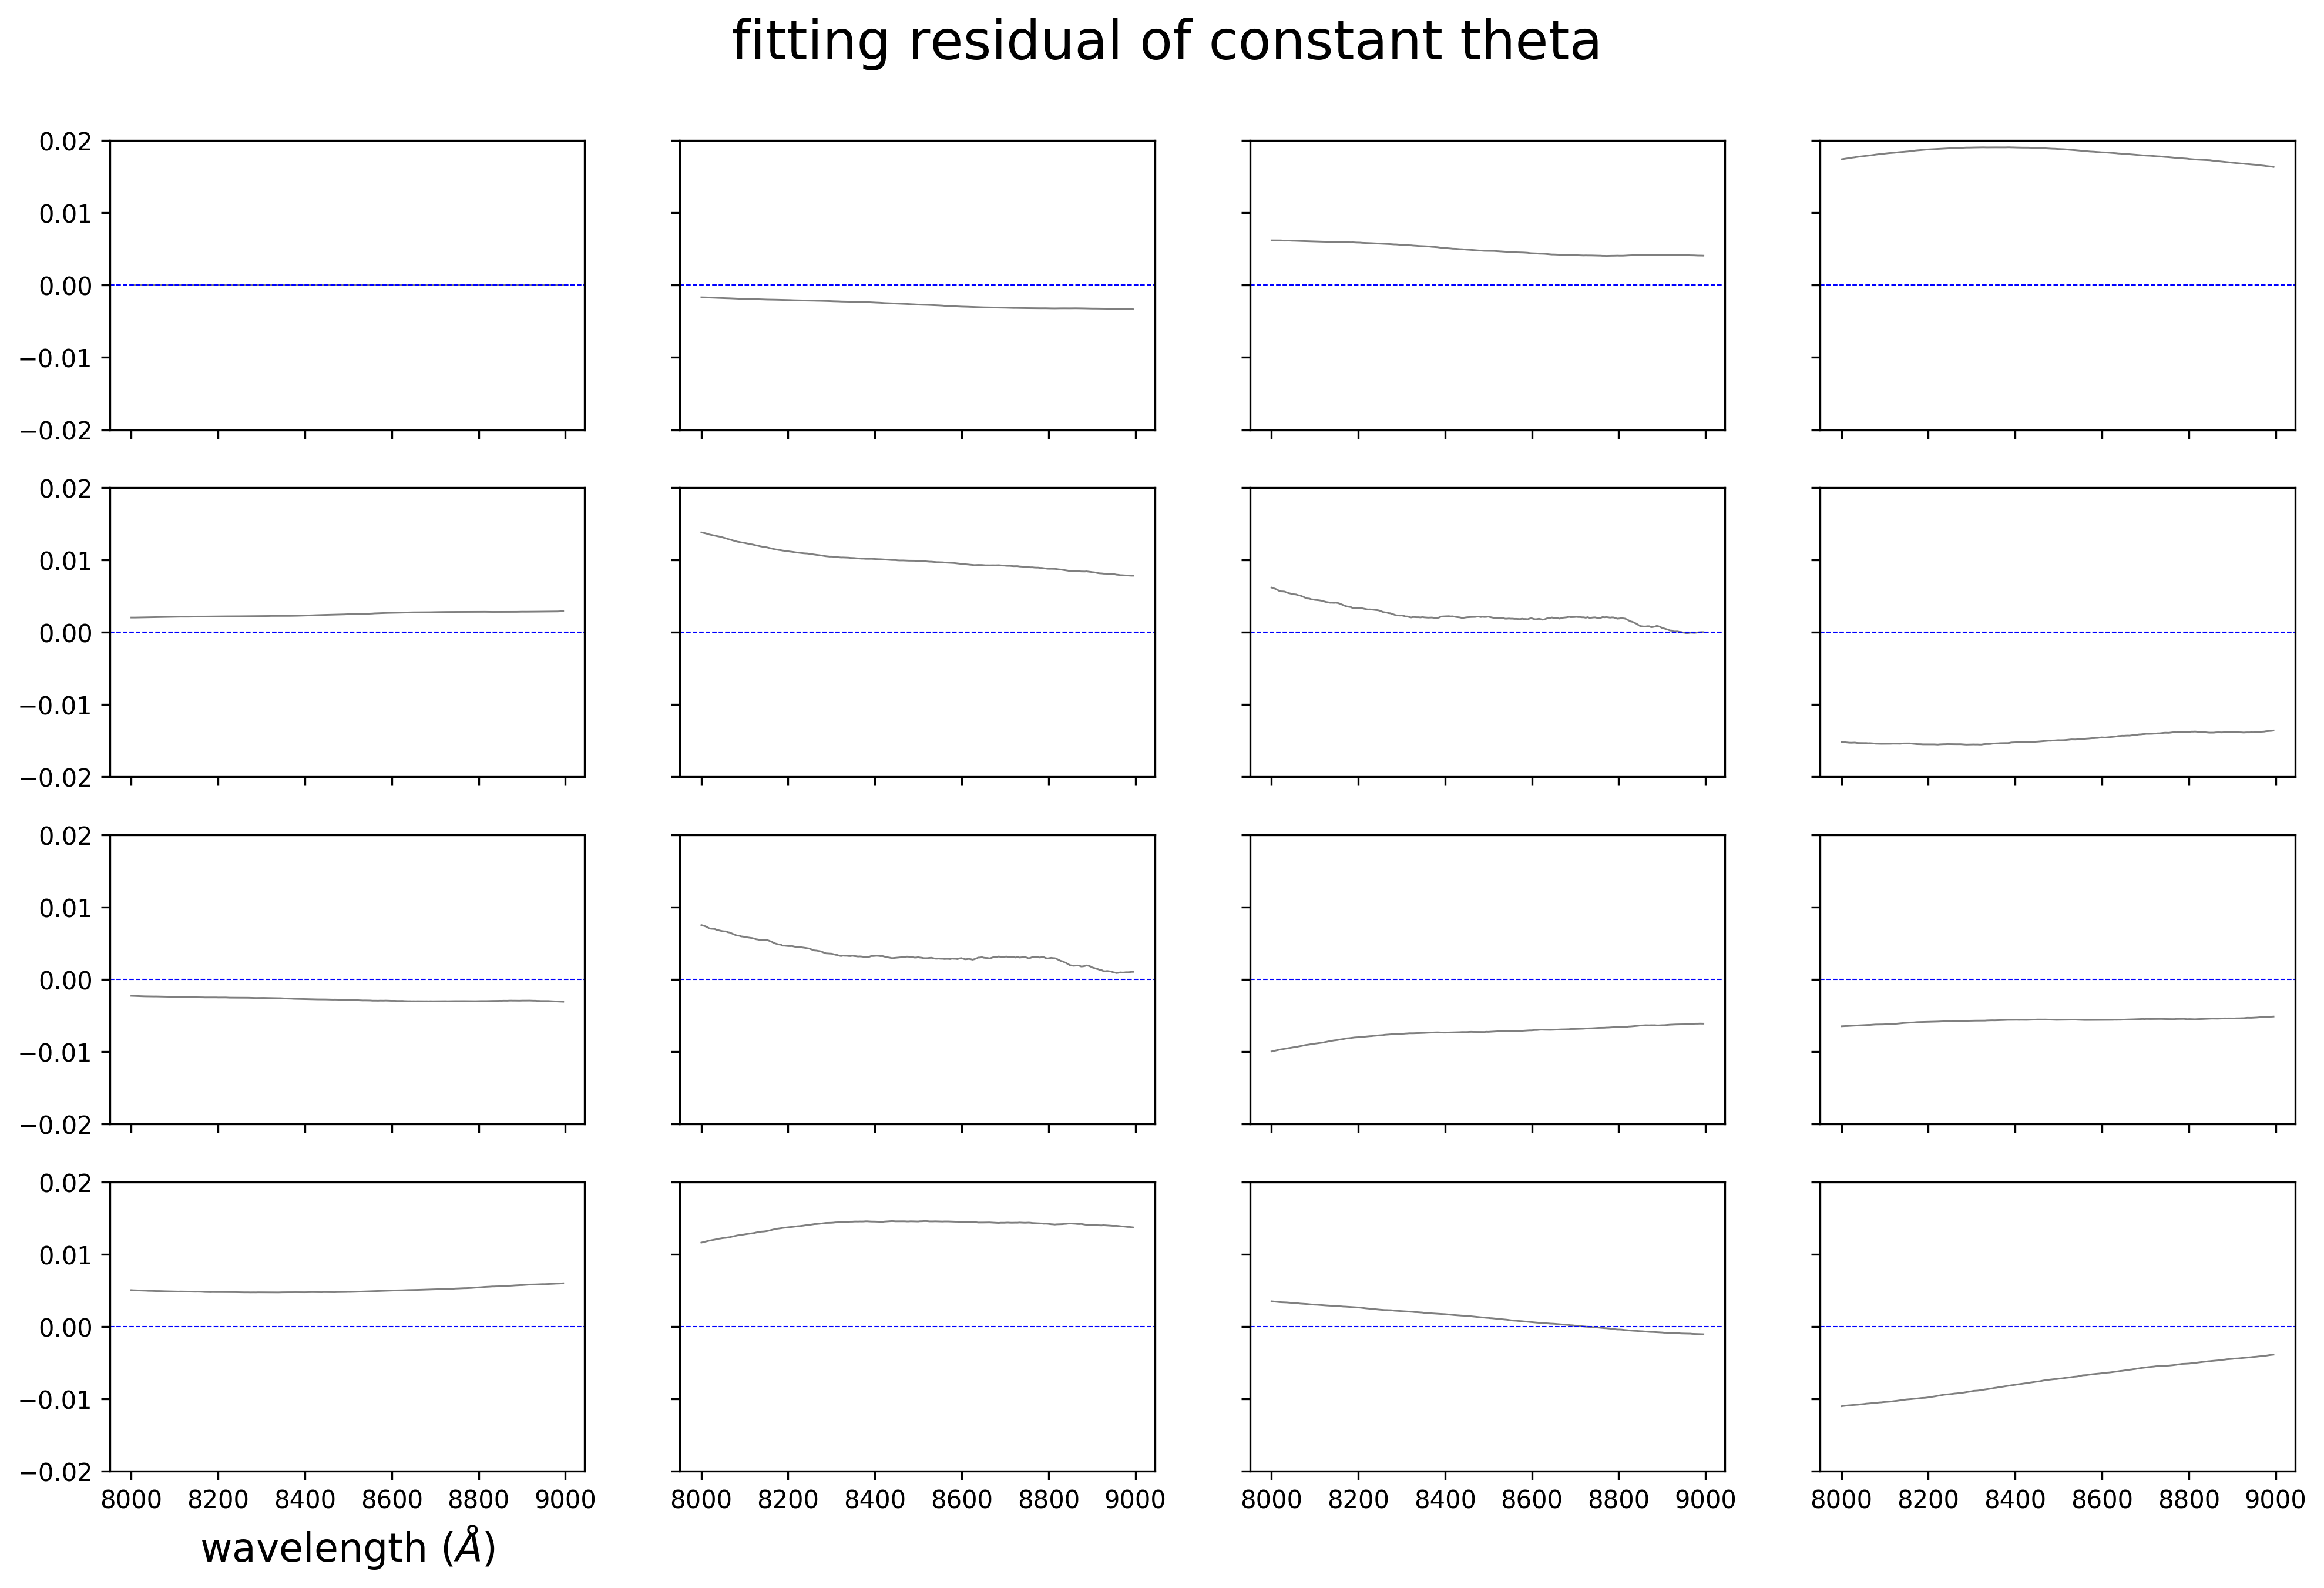

In [413]:
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=300, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(wlFilter[xfit[0]:xfit[1]]*10, fitResidual[:,i,j], '-k', linewidth=0.7, alpha=0.5)
        ax.set_ylim(-1.2,1.2)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')
        ax.set_ylim(-0.02, 0.02)

axs[0,0].legend(loc='best')
axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('fitting residual of constant theta', x=0.5, y=0.95, fontsize=22);

$\theta_0$, $\theta$, $p$s and $\delta$s + depolarizations

In [415]:
result1 = fitMM45(y_data, isthetaConstant=True, isdepol=True, isQU=False, isretardC=False)
fitResidual = result1.residual.reshape(y_data.shape[0],4,4)
result1Array = fittingResult2Array(result1,y_data.shape[0])
lmfit.report_fit(result1)

[[Fit Statistics]]
    # function evals   = 4633
    # data points      = 3696
    # variables        = 925
    chi-square         = 0.230
    reduced chi-square = 0.000
    Akaike info crit   = -33949.868
    Bayesian info crit = -28200.987
[[Variables]]
    theta0:              -0.01678887 +/- 0        (0.00%) (init= 0)
    theta_0:             -0.01803898 +/- 0        (0.00%) (init= 0)
    theta_1:              0          +/- 0        (nan%) (init= 0)
    theta_2:              0          +/- 0        (nan%) (init= 0)
    theta_3:              0          +/- 0        (nan%) (init= 0)
    theta_4:              0          +/- 0        (nan%) (init= 0)
    theta_5:              0          +/- 0        (nan%) (init= 0)
    theta_6:              0          +/- 0        (nan%) (init= 0)
    theta_7:              0          +/- 0        (nan%) (init= 0)
    theta_8:              0          +/- 0        (nan%) (init= 0)
    theta_9:              0          +/- 0        (nan%) (init= 0)
    t

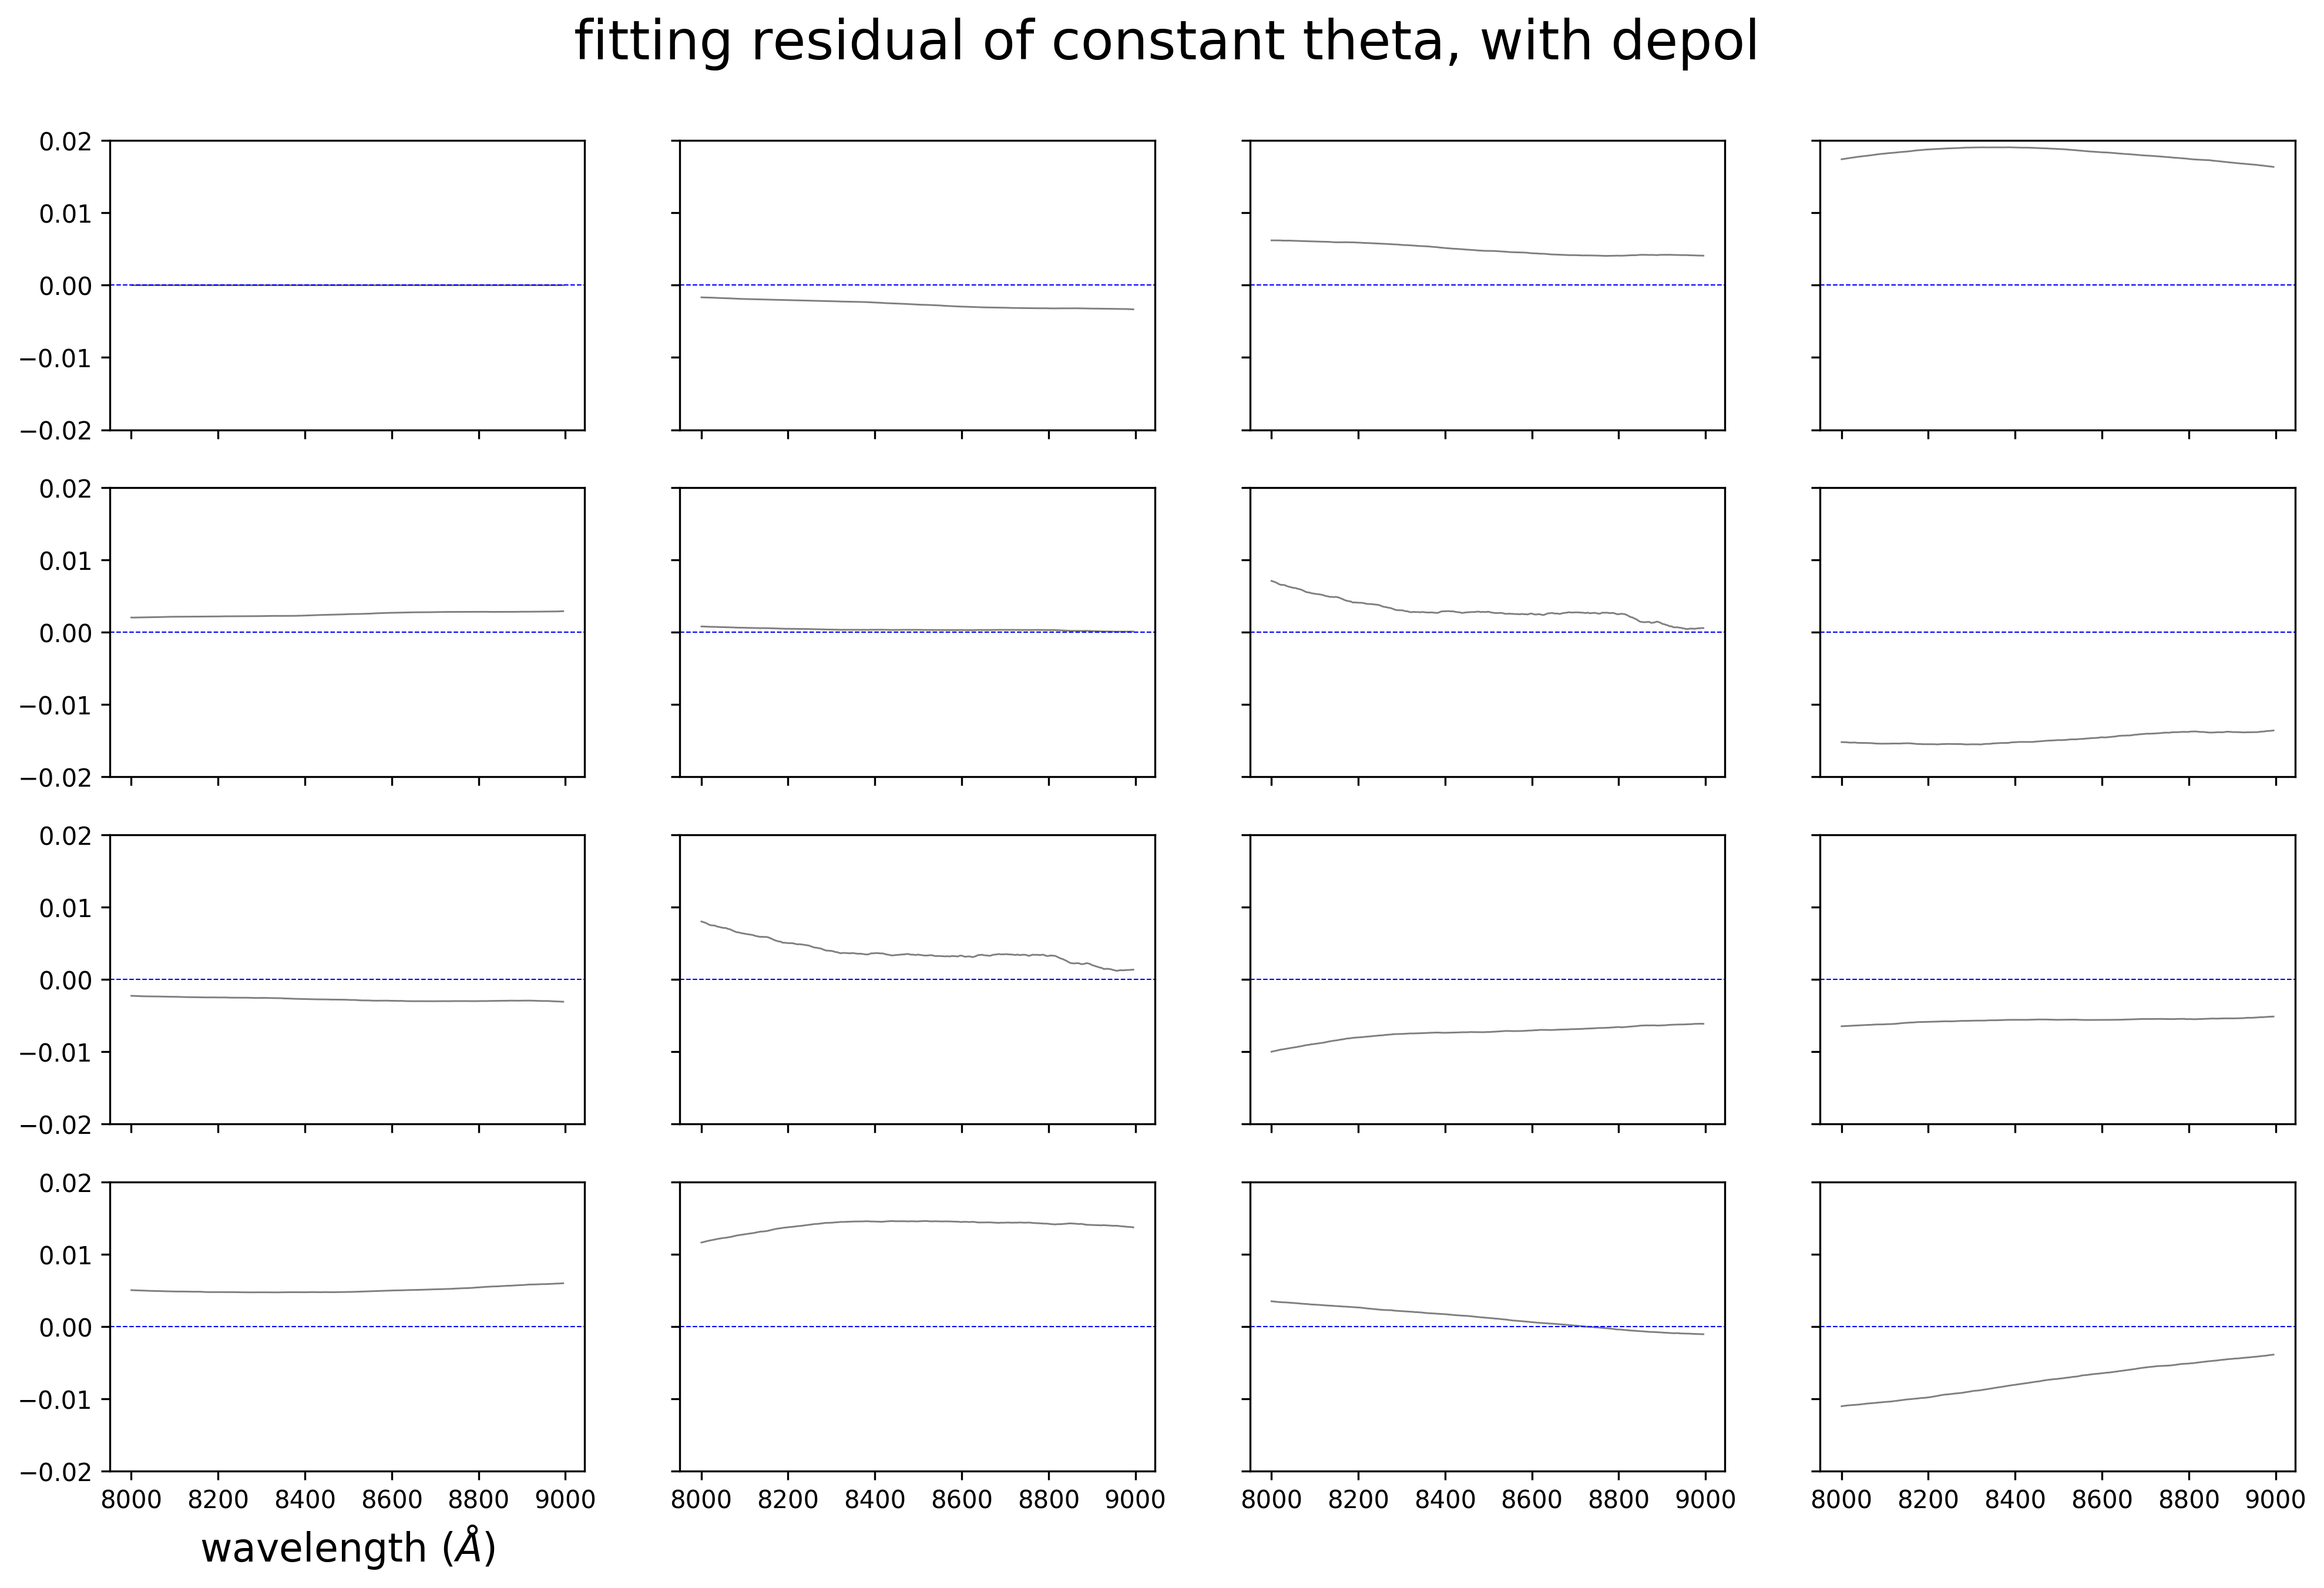

In [416]:
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=300, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(wlFilter[xfit[0]:xfit[1]]*10, fitResidual[:,i,j], '-k', linewidth=0.7, alpha=0.5)
        ax.set_ylim(-1.2,1.2)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')
        ax.set_ylim(-0.02, 0.02)

axs[0,0].legend(loc='best')
axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('fitting residual of constant theta, with depol', x=0.5, y=0.95, fontsize=22);

$\theta_0$, $\theta$, $p$s and $\delta$s + (depolarizations,QU cross-talk)

looks good

In [417]:
result2 = fitMM45(y_data, isthetaConstant=True, isdepol=True, isQU=True, isretardC=False)
fitResidual = result2.residual.reshape(y_data.shape[0],4,4)
result2Array = fittingResult2Array(result2,y_data.shape[0])
lmfit.report_fit(result2)

[[Fit Statistics]]
    # function evals   = 5788
    # data points      = 3696
    # variables        = 1156
    chi-square         = 0.133
    reduced chi-square = 0.000
    Akaike info crit   = -35493.882
    Bayesian info crit = -28309.335
[[Variables]]
    theta0:              -0.01688651 +/- 0        (0.00%) (init= 0)
    theta_0:             -0.00459869 +/- 0        (0.00%) (init= 0)
    theta_1:              0          +/- 0        (nan%) (init= 0)
    theta_2:              0          +/- 0        (nan%) (init= 0)
    theta_3:              0          +/- 0        (nan%) (init= 0)
    theta_4:              0          +/- 0        (nan%) (init= 0)
    theta_5:              0          +/- 0        (nan%) (init= 0)
    theta_6:              0          +/- 0        (nan%) (init= 0)
    theta_7:              0          +/- 0        (nan%) (init= 0)
    theta_8:              0          +/- 0        (nan%) (init= 0)
    theta_9:              0          +/- 0        (nan%) (init= 0)
    

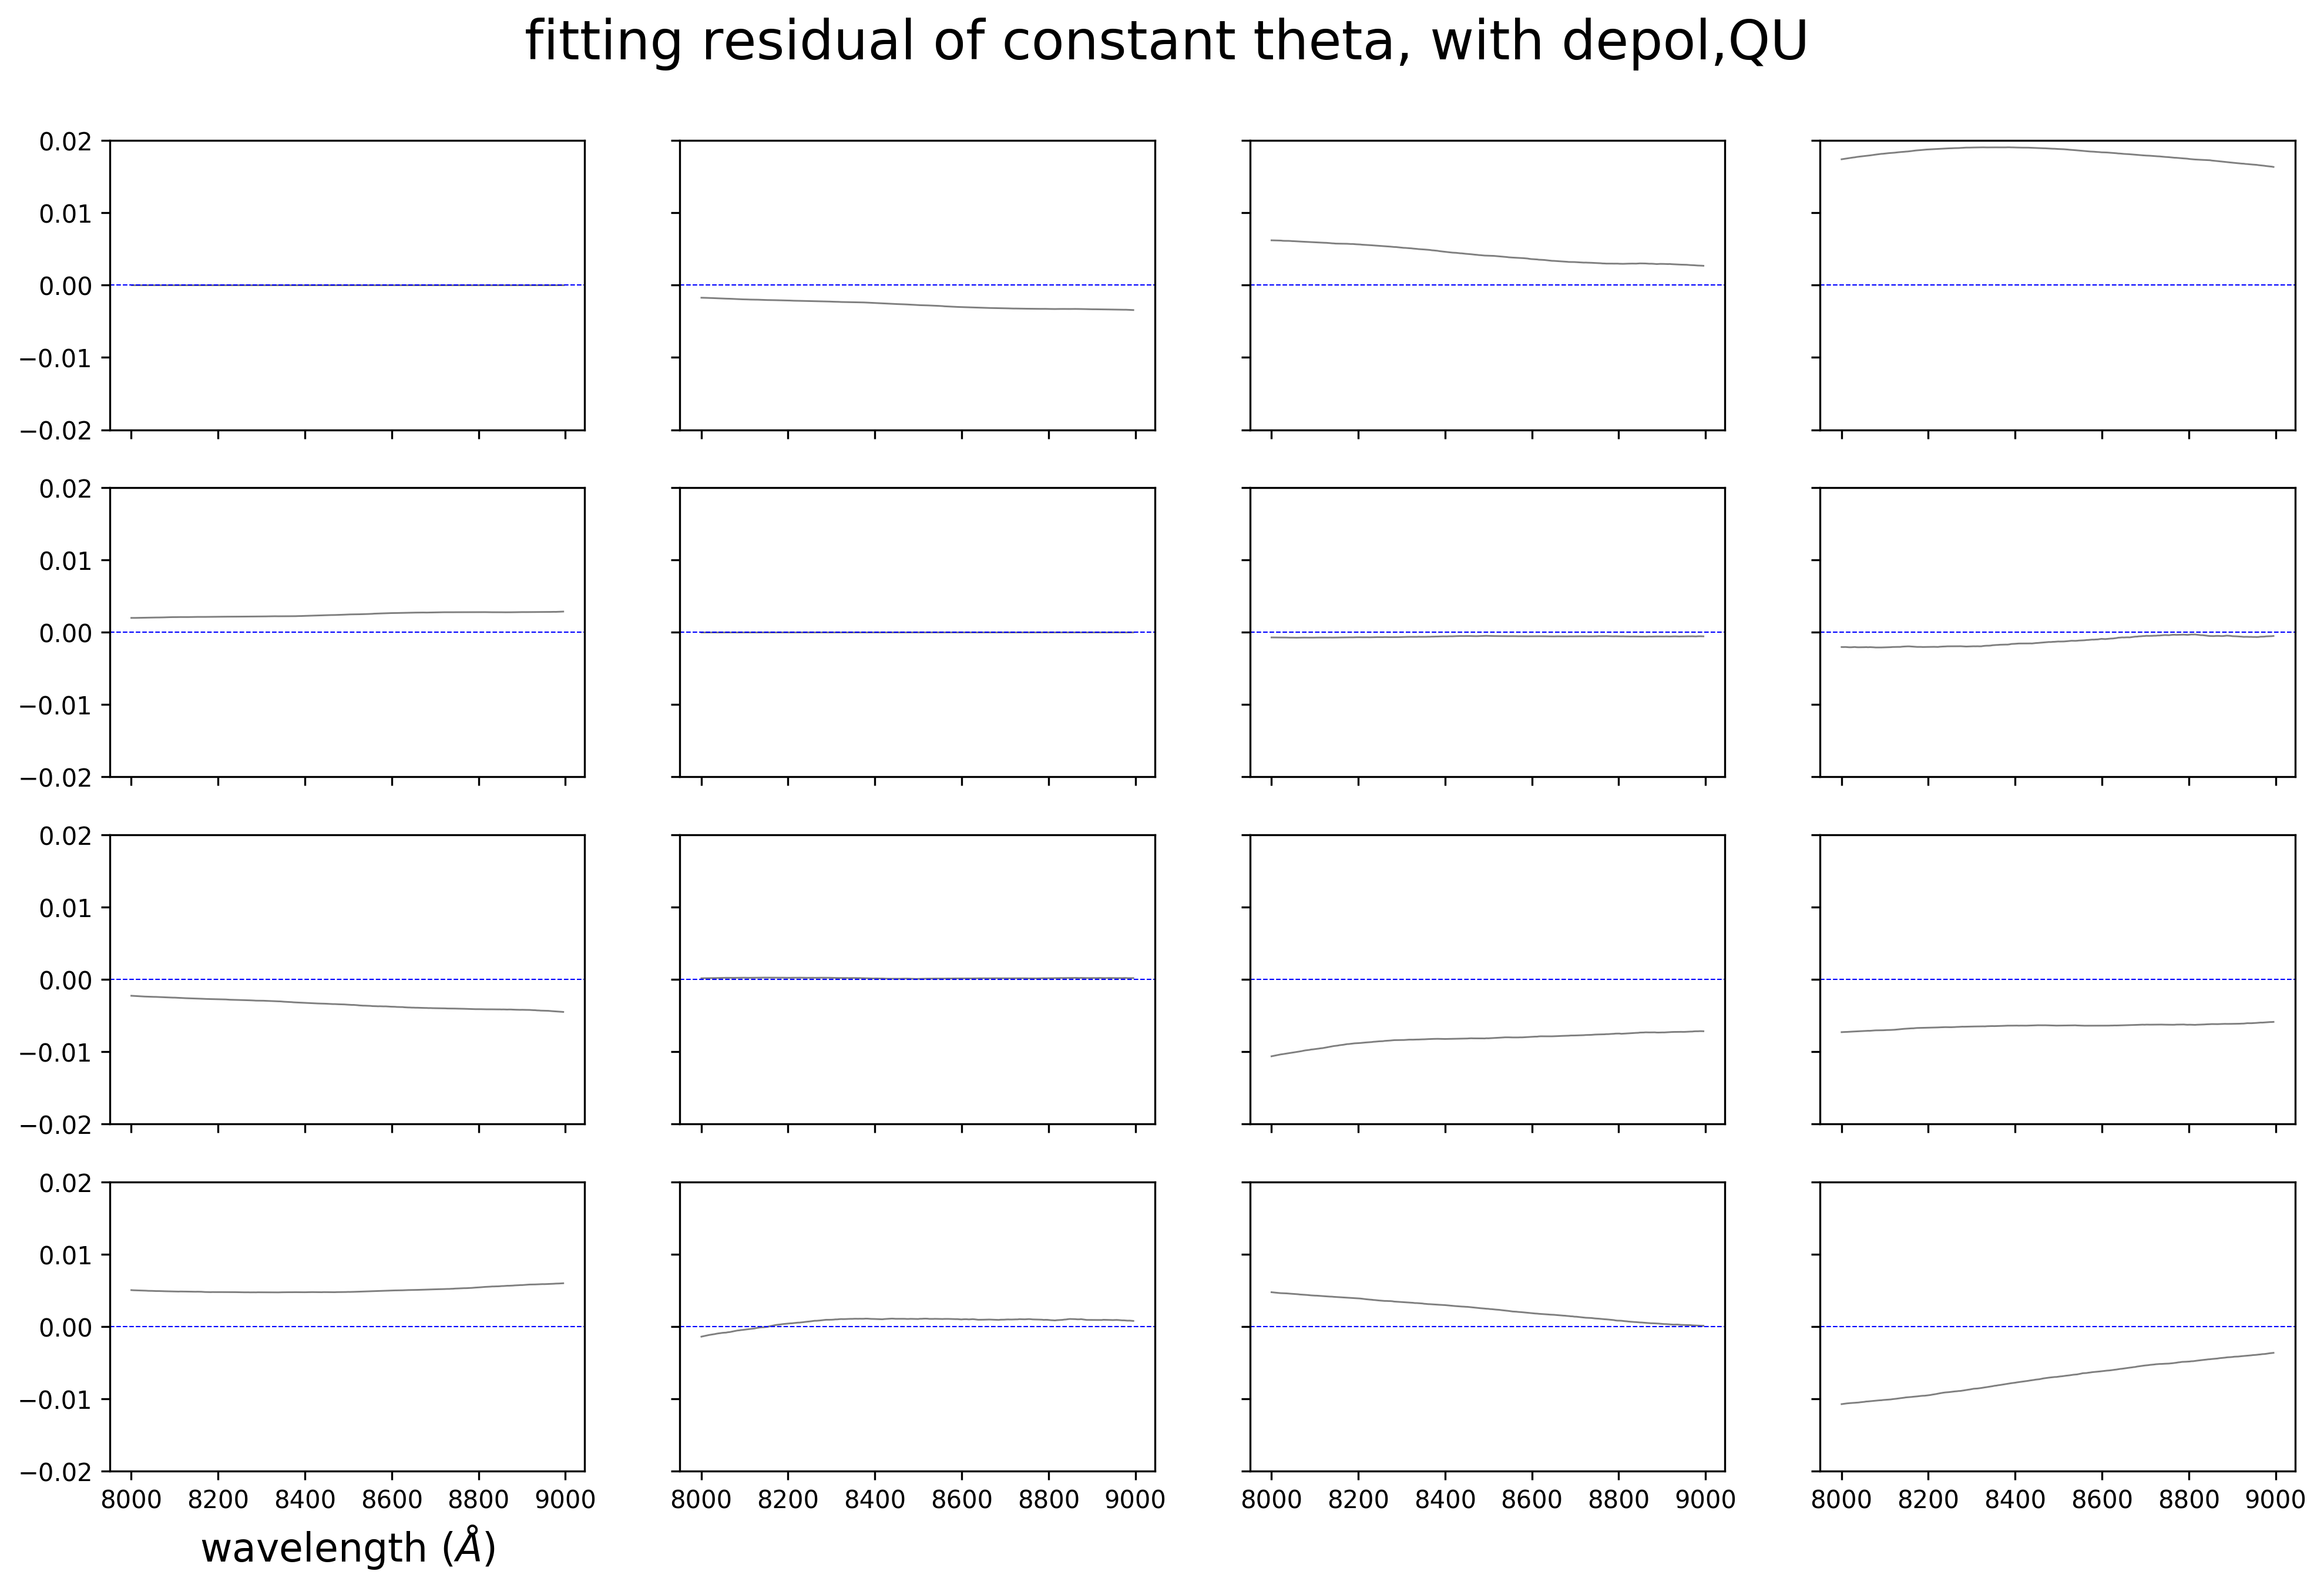

In [418]:
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=300, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(wlFilter[xfit[0]:xfit[1]]*10, fitResidual[:,i,j], '-k', linewidth=0.7, alpha=0.5)
        ax.set_ylim(-1.2,1.2)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')
        ax.set_ylim(-0.02, 0.02)

axs[0,0].legend(loc='best')
axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('fitting residual of constant theta, with depol,QU', x=0.5, y=0.95, fontsize=22);

$\theta_0$, $\theta$, $p$s and $\delta$s + (depolarizations,QU cross-talk, IU cross-talk)

IU cross talk has values smaller than 0.002, can be ignored due because noise level is 0.002

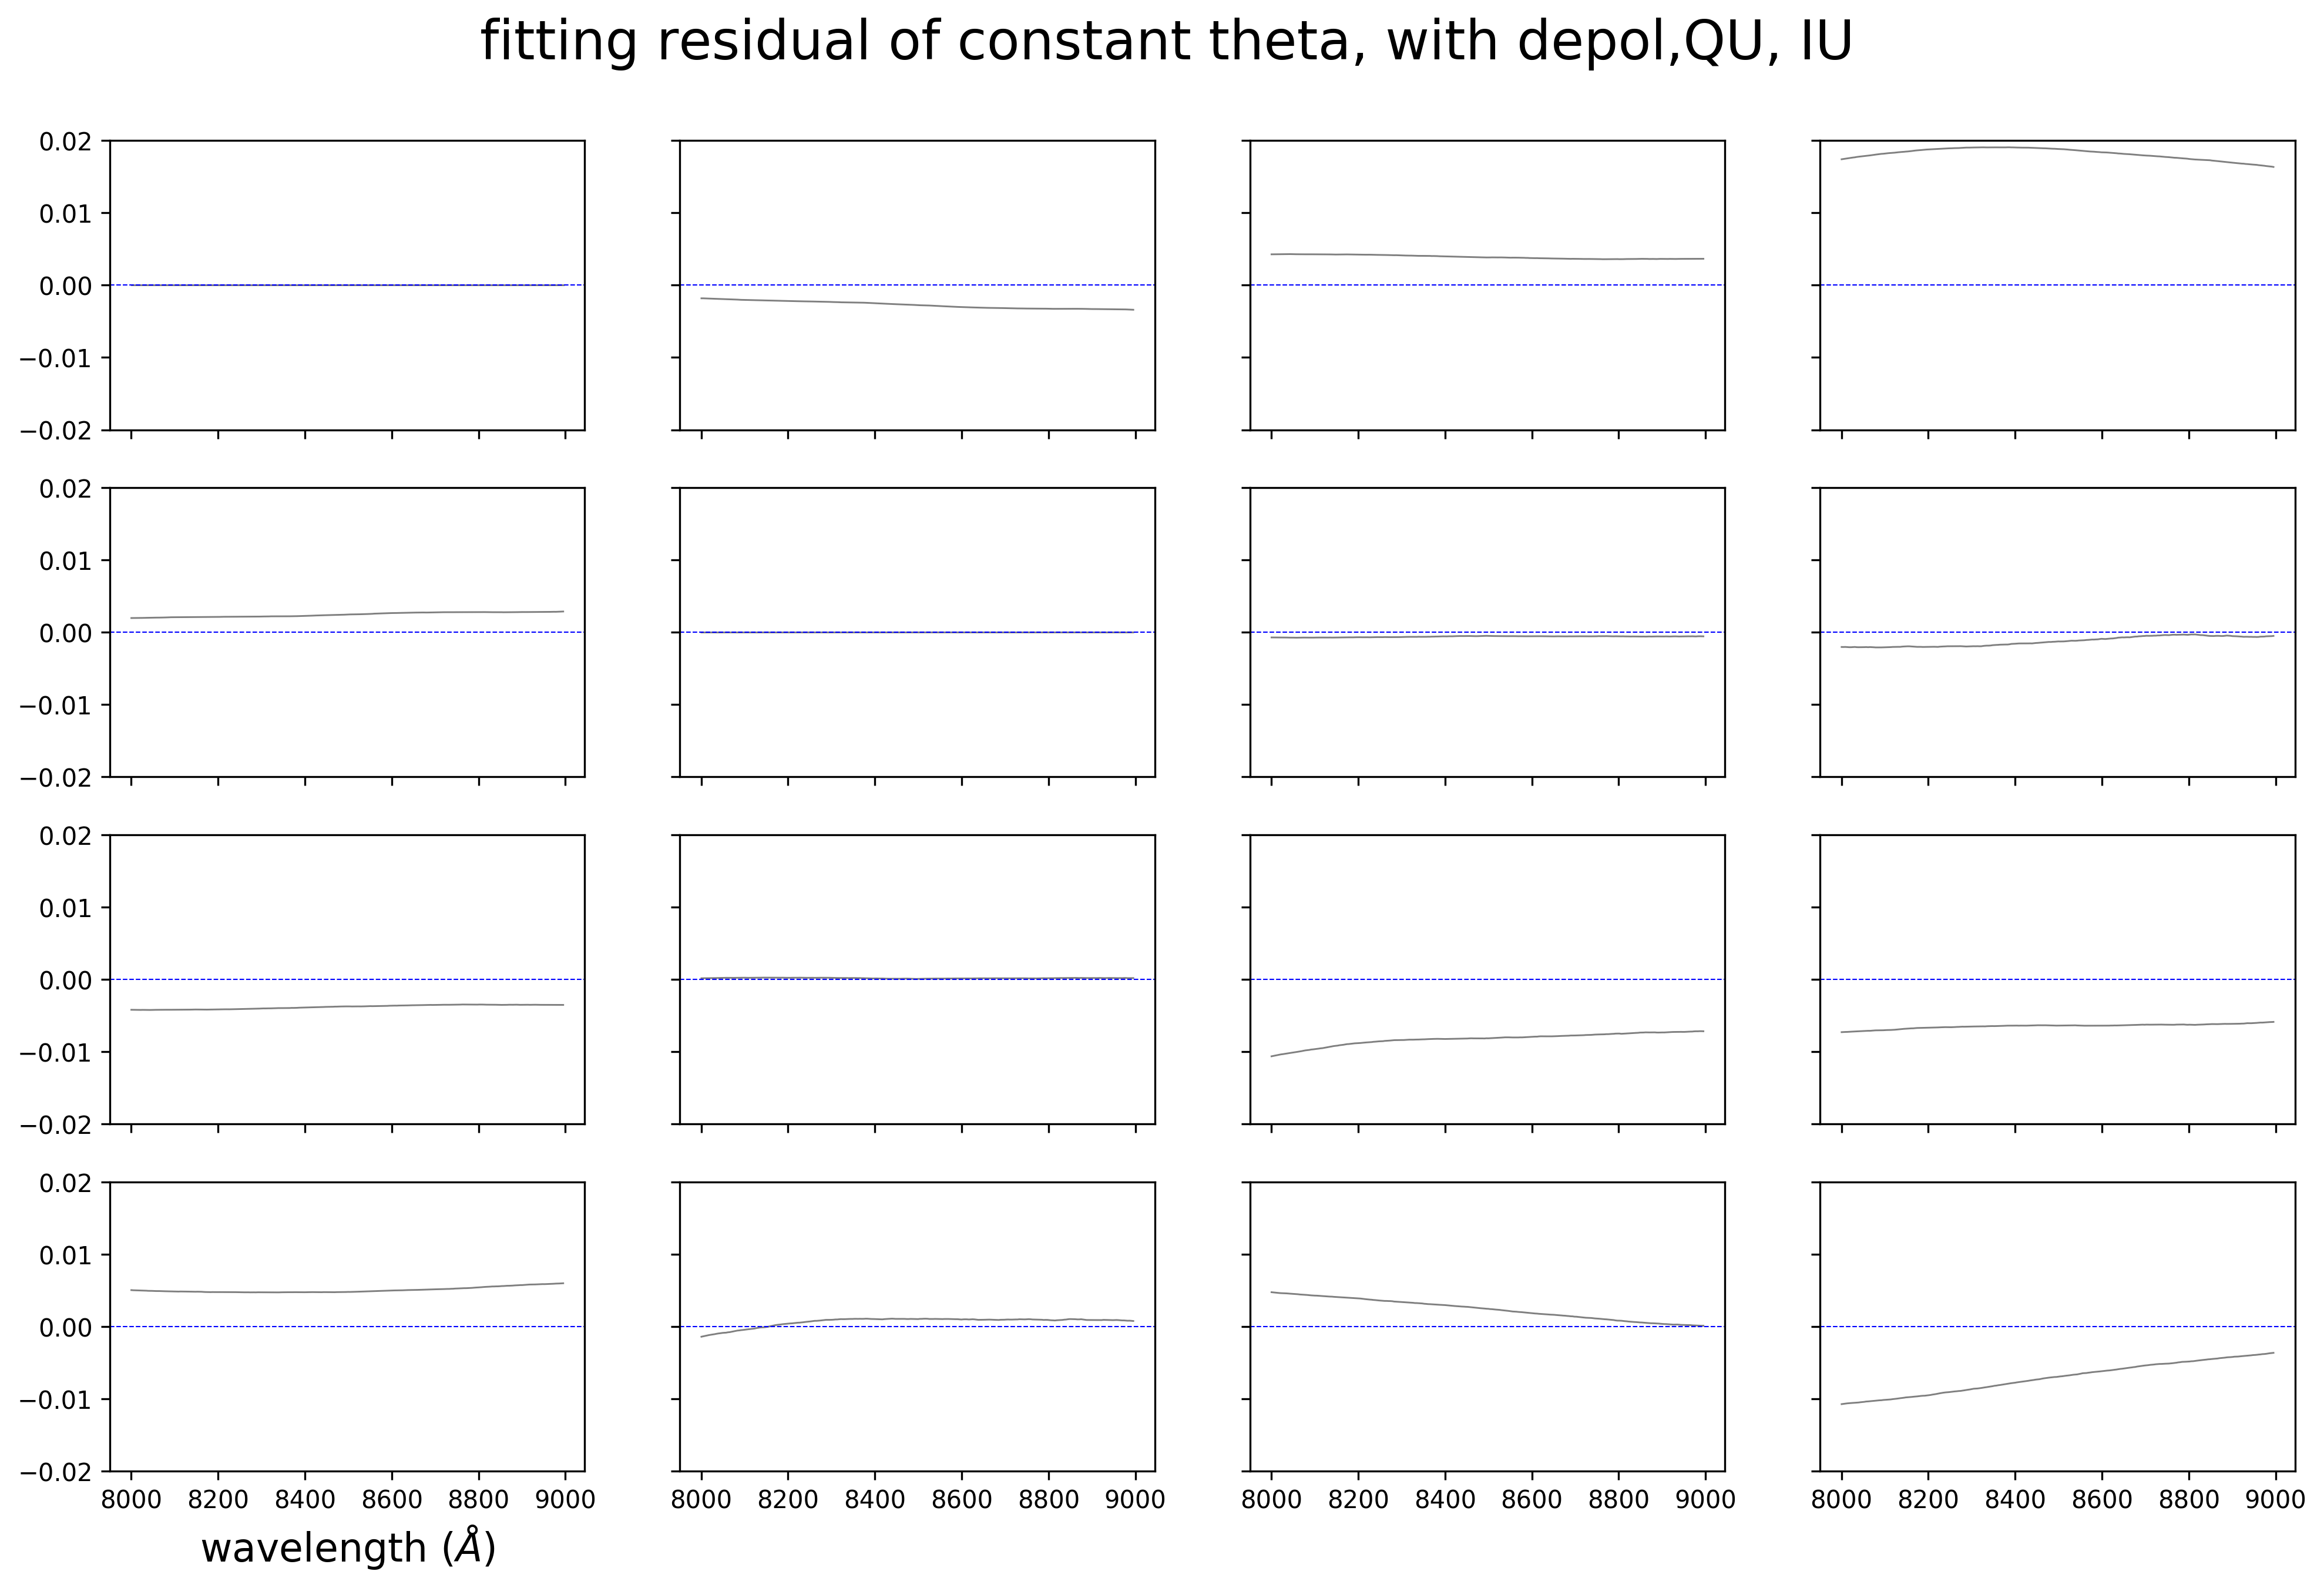

In [405]:
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=300, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(wlFilter[xfit[0]:xfit[1]]*10, fitResidual[:,i,j], '-k', linewidth=0.7, alpha=0.5)
        ax.set_ylim(-1.2,1.2)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')
        ax.set_ylim(-0.02, 0.02)

axs[0,0].legend(loc='best')
axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('fitting residual of constant theta, with depol,QU, IU', x=0.5, y=0.95, fontsize=22);

$\theta_0$, $\theta$, $p$s and $\delta$s + (depolarizations,QU cross-talk, retardConstant)

In [419]:
result3 = fitMM45(y_data, isthetaConstant=True, isdepol=True, isQU=True, isretardC=True)
fitResidual = result3.residual.reshape(y_data.shape[0],4,4)
result3Array = fittingResult2Array(result3,y_data.shape[0])
lmfit.report_fit(result3)

[[Fit Statistics]]
    # function evals   = 5555
    # data points      = 3696
    # variables        = 1387
    chi-square         = 0.096
    reduced chi-square = 0.000
    Akaike info crit   = -36265.500
    Bayesian info crit = -27645.286
[[Variables]]
    theta0:              -0.01687238 +/- 0        (0.00%) (init= 0)
    theta_0:             -0.00379870 +/- 0        (0.00%) (init= 0)
    theta_1:              0          +/- 0        (nan%) (init= 0)
    theta_2:              0          +/- 0        (nan%) (init= 0)
    theta_3:              0          +/- 0        (nan%) (init= 0)
    theta_4:              0          +/- 0        (nan%) (init= 0)
    theta_5:              0          +/- 0        (nan%) (init= 0)
    theta_6:              0          +/- 0        (nan%) (init= 0)
    theta_7:              0          +/- 0        (nan%) (init= 0)
    theta_8:              0          +/- 0        (nan%) (init= 0)
    theta_9:              0          +/- 0        (nan%) (init= 0)
    

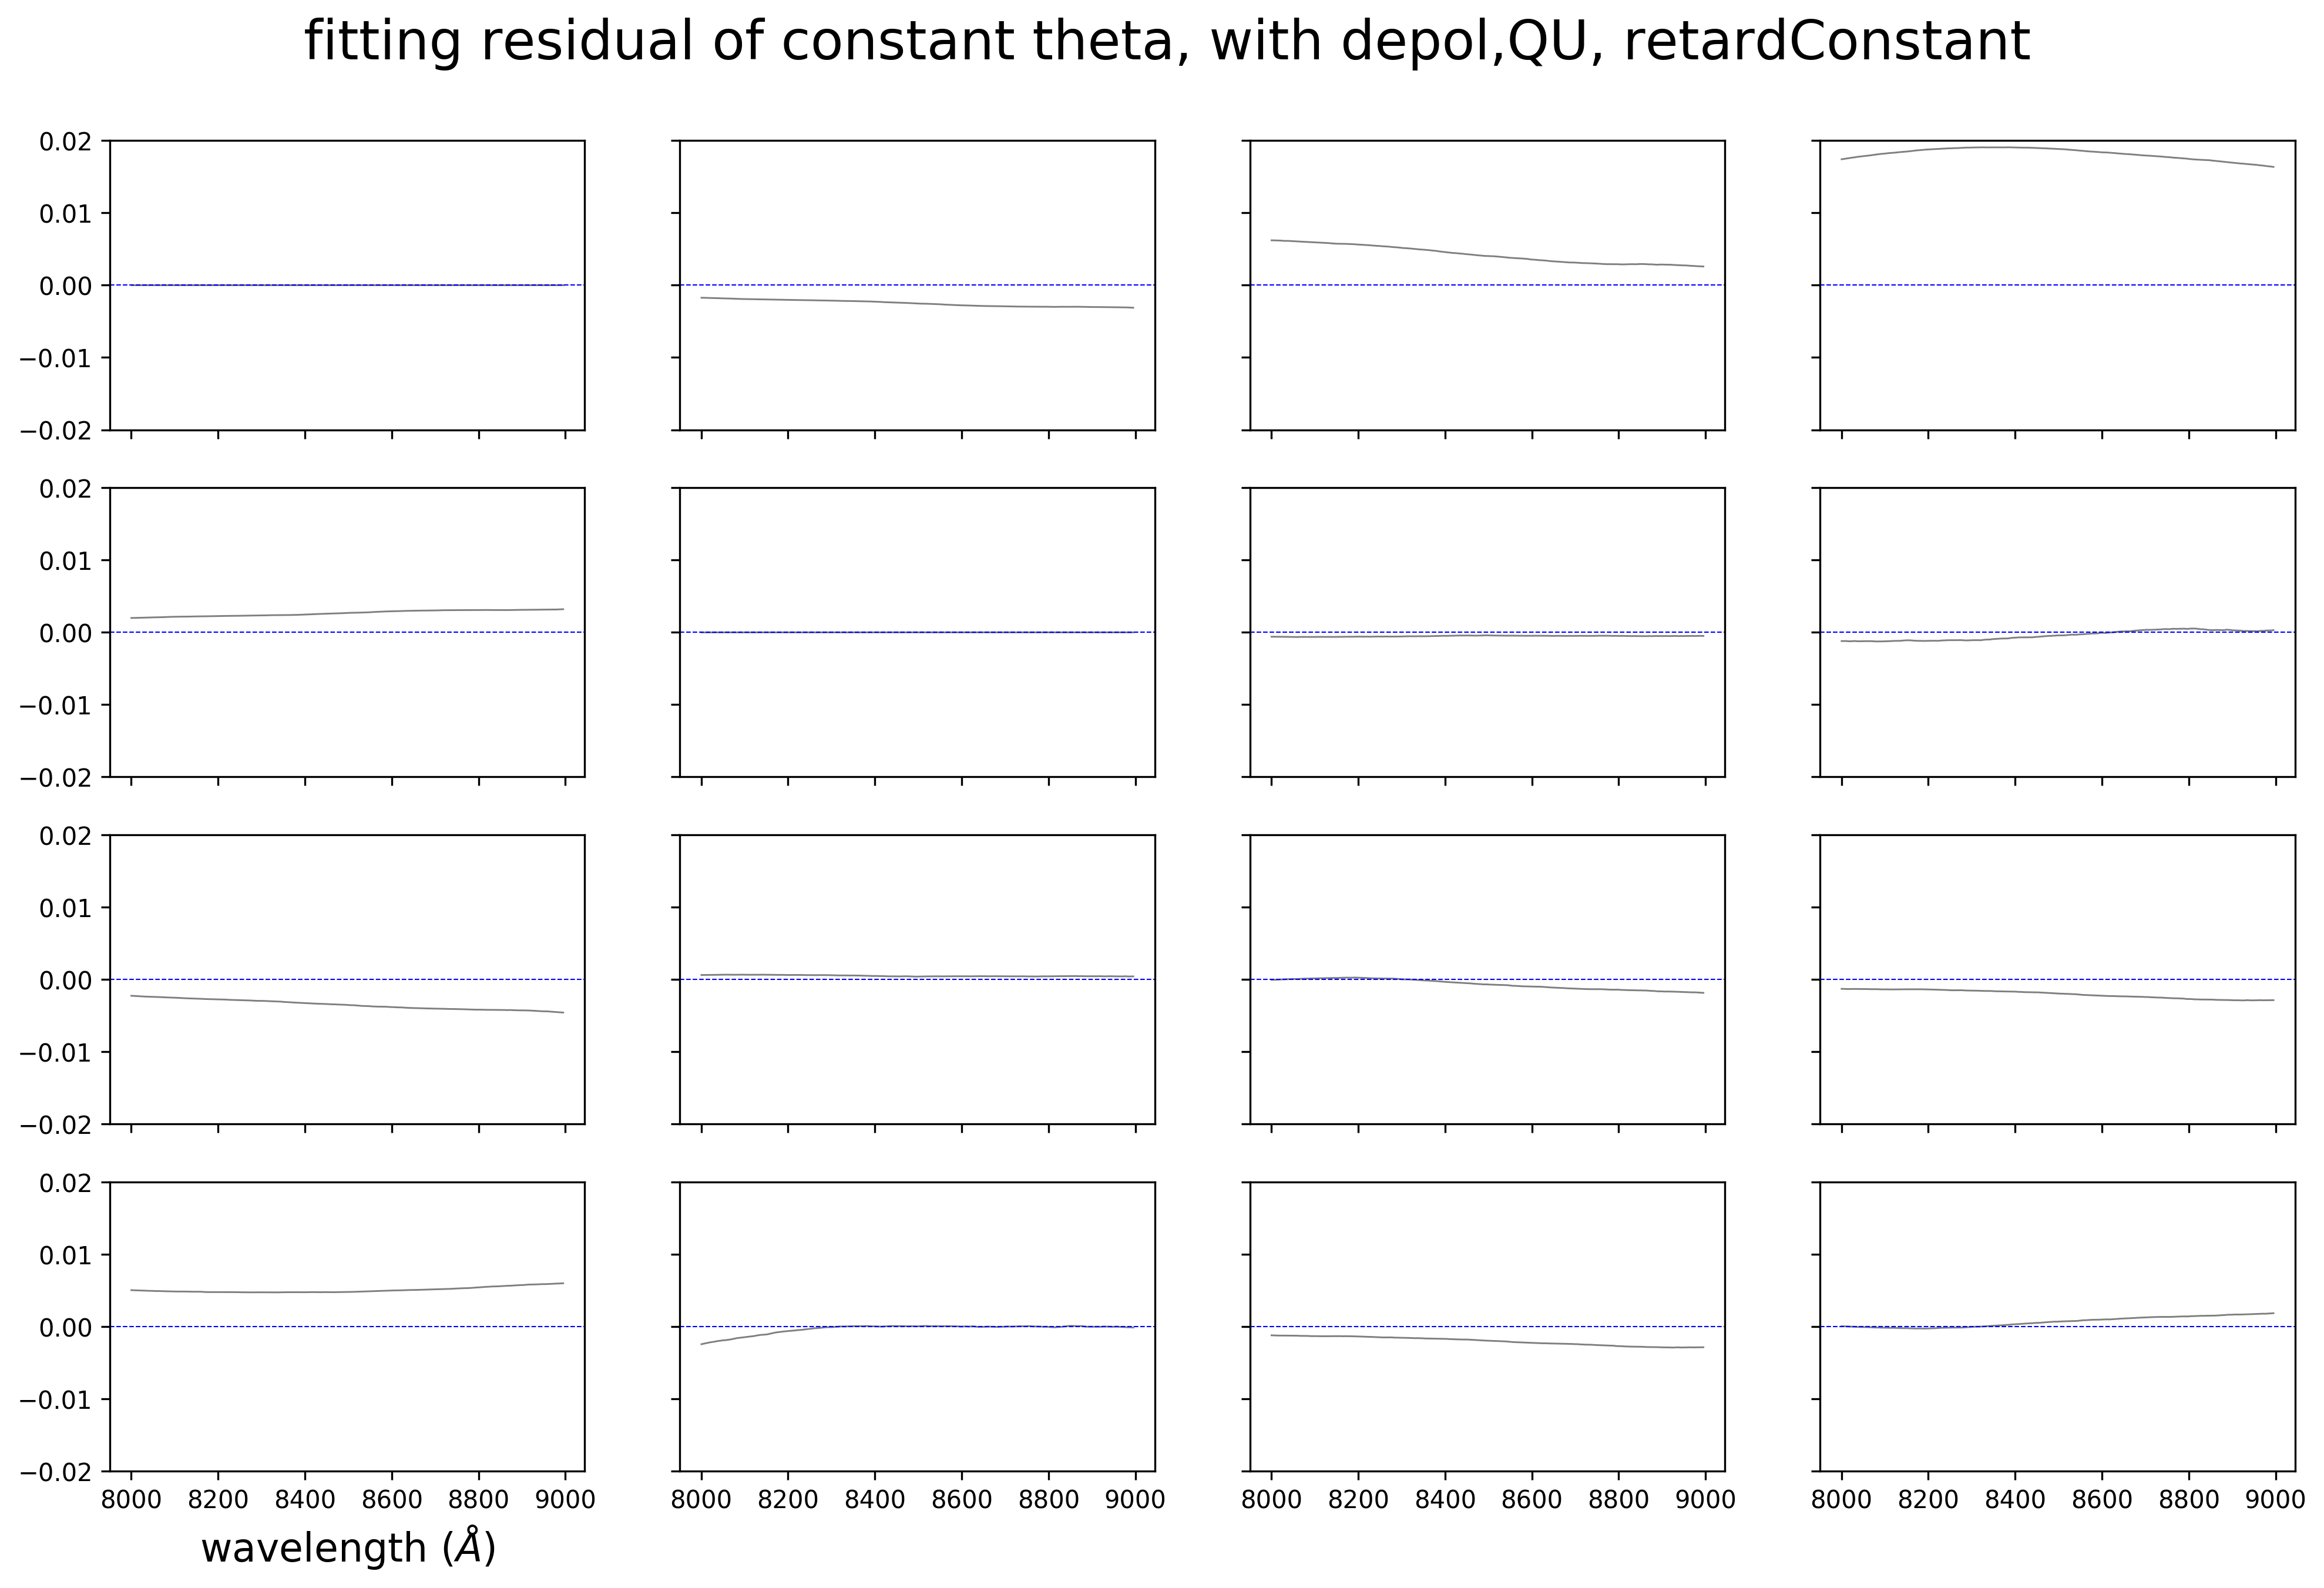

In [420]:
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=300, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(wlFilter[xfit[0]:xfit[1]]*10, fitResidual[:,i,j], '-k', linewidth=0.7, alpha=0.5)
        ax.set_ylim(-1.2,1.2)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')
        ax.set_ylim(-0.02, 0.02)

axs[0,0].legend(loc='best')
axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('fitting residual of constant theta, with depol,QU, retardConstant', x=0.5, y=0.95, fontsize=22);

#### parameter variance

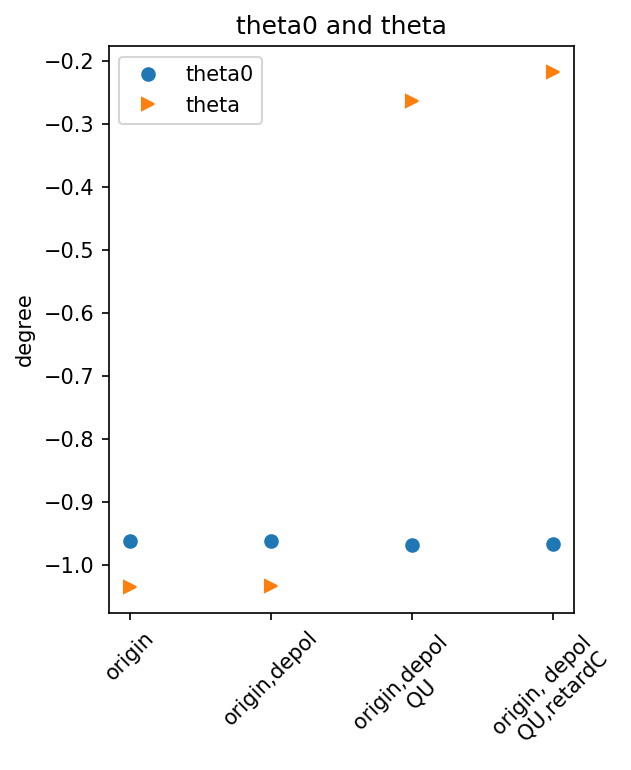

In [454]:
fig, ax = plt.subplots(1,1, figsize=(4,5), dpi=150)
theta0List = []
thetaList = []
for _ in [result0Array,result1Array,result2Array,result3Array]:
    theta0List.append(np.rad2deg(_[0]))
    thetaList.append(np.rad2deg(_[1][0]))
ax.plot([0,1,2,3], theta0List, 'o', label='theta0')
ax.plot([0,1,2,3], thetaList, '>', label="theta")
ax.legend(loc="best")
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["origin", "origin,depol", "origin,depol \n QU", "origin, depol \n QU,retardC"], rotation=45, fontsize=10)
ax.set_ylabel("degree")
ax.set_title("theta0 and theta");

theta0, thetaArray, pArray, deltaArray, depolArray, QUArray, retardCArray

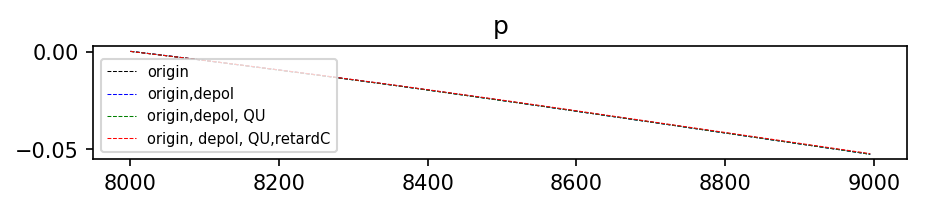

In [475]:
fig, ax = plt.subplots(1,1, figsize=(7,1), dpi=150)
labels = ["origin", "origin,depol", "origin,depol, QU", "origin, depol, QU,retardC"]
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, result0Array[2], '--k', linewidth=0.5, markersize=1, label=labels[0])
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, result1Array[2], '--b', linewidth=0.5, markersize=1, label=labels[1])
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, result2Array[2], '--g', linewidth=0.5, markersize=1, label=labels[2])
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, result3Array[2], '--r', linewidth=0.5, markersize=1, label=labels[3])
ax.legend(loc="best", fontsize=7)
ax.set_title("p");
#ax.set_xlabel("wavelength ($\AA$)");

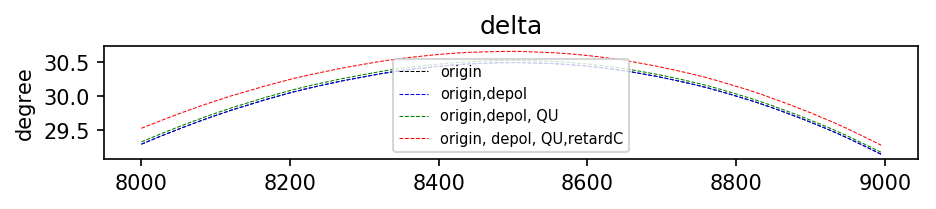

In [481]:
fig, ax = plt.subplots(1,1, figsize=(7,1), dpi=150)
labels = ["origin", "origin,depol", "origin,depol, QU", "origin, depol, QU,retardC"]
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, np.rad2deg(result0Array[3]), '--k', linewidth=0.5, markersize=1, label=labels[0])
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, np.rad2deg(result1Array[3]), '--b', linewidth=0.5, markersize=1, label=labels[1])
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, np.rad2deg(result2Array[3]), '--g', linewidth=0.5, markersize=1, label=labels[2])
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, np.rad2deg(result3Array[3]), '--r', linewidth=0.5, markersize=1, label=labels[3])
ax.legend(loc="best", fontsize=7)
ax.set_ylabel("degree")
ax.set_title("delta");
#ax.set_xlabel("wavelength ($\AA$)");

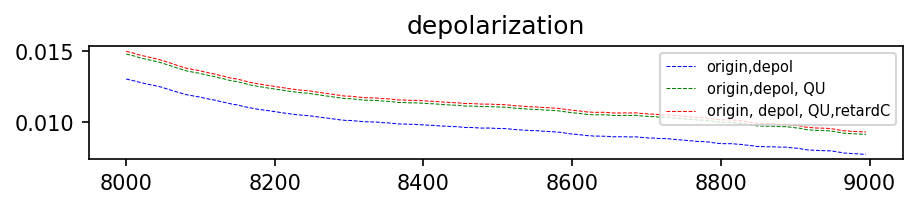

In [474]:
fig, ax = plt.subplots(1,1, figsize=(7,1), dpi=150)
labels = ["origin", "origin,depol", "origin,depol, QU", "origin, depol, QU,retardC"]
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, result1Array[4], '--b', linewidth=0.5, markersize=1, label=labels[1])
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, result2Array[4], '--g', linewidth=0.5, markersize=1, label=labels[2])
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, result3Array[4], '--r', linewidth=0.5, markersize=1, label=labels[3])
ax.legend(loc="best", fontsize=7)
ax.set_title("depolarization");
#ax.set_xlabel("wavelength ($\AA$)");

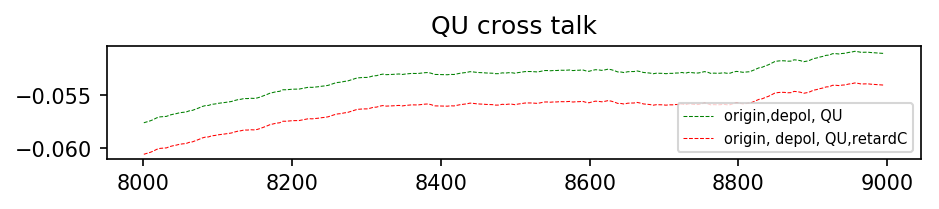

In [478]:
fig, ax = plt.subplots(1,1, figsize=(7,1), dpi=150)
labels = ["origin", "origin,depol", "origin,depol, QU", "origin, depol, QU,retardC"]
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, result2Array[5], '--g', linewidth=0.5, markersize=1, label=labels[2])
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, result3Array[5], '--r', linewidth=0.5, markersize=1, label=labels[3])
ax.legend(loc="best", fontsize=7)
ax.set_title("QU cross talk");
#ax.set_xlabel("wavelength ($\AA$)");

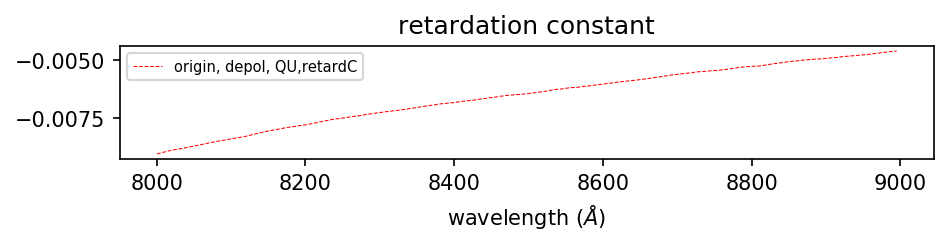

In [480]:
fig, ax = plt.subplots(1,1, figsize=(7,1), dpi=150)
labels = ["origin", "origin,depol", "origin,depol, QU", "origin, depol, QU,retardC"]
ax.plot(wlFilter[xfit[0]:xfit[1]]*10, result3Array[6], '--r', linewidth=0.5, markersize=1, label=labels[3])
ax.legend(loc="best", fontsize=7)
ax.set_title("retardation constant");
ax.set_xlabel("wavelength ($\AA$)");

relation between `p` and `retardC` ?

### fit angle `theta` seperately

In [ ]:
result_sep = fitMM45(y_data, isthetaConstant=False)

---

# Symbolic matrix analysis

In [107]:
result.params

Parameters([('theta',
  <Parameter 'theta', value=-0.030435644421859531 +/- 0.00211, bounds=[-1.0:1.0]>),
 ('p',
  <Parameter 'p', value=0.022068286671217296 +/- 0.00822, bounds=[-0.5:0.5]>),
 ('delta',
  <Parameter 'delta', value=0.44788029475203484 +/- 0.00822, bounds=[-3.141592653589793:3.141592653589793]>)])

In [101]:
print(result.residual.reshape(4,4))

[[ 0.          0.00584241  0.00722088 -0.00190281]
 [-0.00300424  0.01078939  0.00012955 -0.04446389]
 [-0.00407858 -0.00569508 -0.01426947 -0.00316556]
 [ 0.03156478 -0.01405783 -0.01091478 -0.03618005]]


In [317]:
sym.init_printing?

In [318]:
import sympy as sym
sym.init_printing(wrap_line=True)

## Mirror's Mueller Matrix 

In [64]:
delta, p = sym.symbols('delta, p')
delta, p

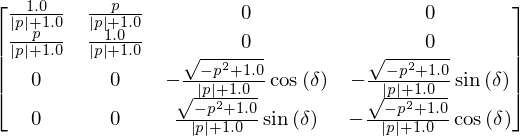

In [65]:
mm_mirror = sym.Matrix([
            [1., p, 0., 0.],
            [p, 1., 0., 0.],
            [0., 0., -sym.sqrt(1.-p*p)*sym.cos(delta), -sym.sqrt(1.-p*p)*sym.sin(delta)],
            [0., 0., +sym.sqrt(1.-p*p)*sym.sin(delta), -sym.sqrt(1.-p*p)*sym.cos(delta)]
        ]) / (1.+abs(p))
mm_mirror

## rotation matrix

In [78]:
def MuellerMatrixRotationSymbol(theta):
    
    # this assert will false if we input -theta
    # assert isinstance(theta, sym.Symbol), "argument theta must be a sympy.Symbol"
    
    c2 = sym.cos(2 * theta)
    s2 = sym.sin(2 * theta)
    
    mat = sym.Matrix([
        [1, 0  , 0 , 0 ],
        [0, c2 , s2, 0 ],
        [0, -s2, c2, 0 ],
        [0, 0  , 0 , 1 ]
    ])
    
    return mat

In [67]:
theta = sym.symbols("theta")
theta

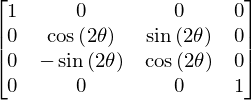

In [79]:
MuellerMatrixRotationSymbol(theta)

## Mueller Matrix of rotated Mirror

In [508]:
np.rad2deg( np.arccos(-0.5) )

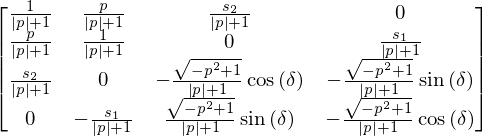

In [312]:
s1,s2 = sym.symbols("s1,s2")
mm_mirror = sym.Matrix([
            [1, p, s2, 0],
            [p, 1, 0, s1],
            [s2, 0, -sym.sqrt(1-p*p)*sym.cos(delta), -sym.sqrt(1-p*p)*sym.sin(delta)],
            [0, -s1, +sym.sqrt(1-p*p)*sym.sin(delta), -sym.sqrt(1-p*p)*sym.cos(delta)]
        ]) / (1+abs(p))
mm_mirror

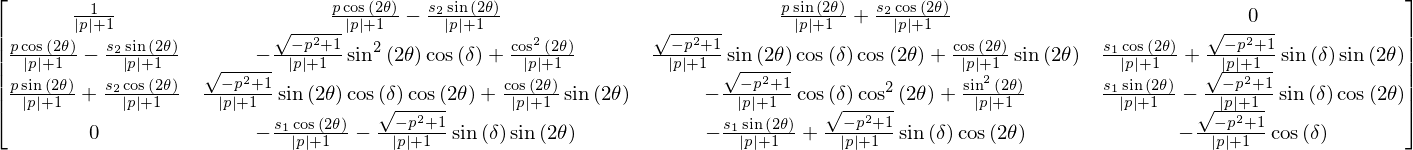

In [313]:
mm_mirror_rotated = MuellerMatrixRotationSymbol(-theta) * mm_mirror * MuellerMatrixRotationSymbol(theta)
mm_mirror_rotated 

original

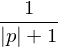

In [493]:
mm_mirror_rotated[0,0]

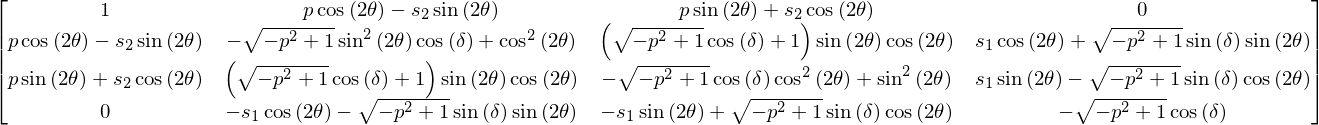

In [495]:
mm_mirror_rotated = MuellerMatrixRotationSymbol(-theta) * mm_mirror * MuellerMatrixRotationSymbol(theta)
sym.simplify( mm_mirror_rotated  / mm_mirror_rotated[0,0] )

we found that, if $\lim_{p \to 0, \theta \to 0}$

- $m_{02} = m_{20} \to (O^2)$
- $m_{03} = m_{30} = 0$
- $m_{12} = m_{21} \to (O^1)$
- $m_{13} = -m_{31} \ to (O^1)$

if a full 4x4 matrix is rotated

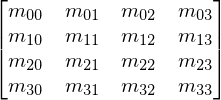

In [315]:
m00, m01, m02, m03, m10, m11, m12, m13, m20, m21, m22, m23, m30, m31, m32, m33 = sym.symbols("m00, m01, m02, m03, m10, m11, m12, m13, m20, m21, m22, m23, m30, m31, m32, m33")
mm_full = sym.Matrix([
    [m00, m01, m02, m03],
    [m10, m11, m12, m13],
    [m20, m21, m22, m23],
    [m30, m31, m32, m33]
])
mm_full

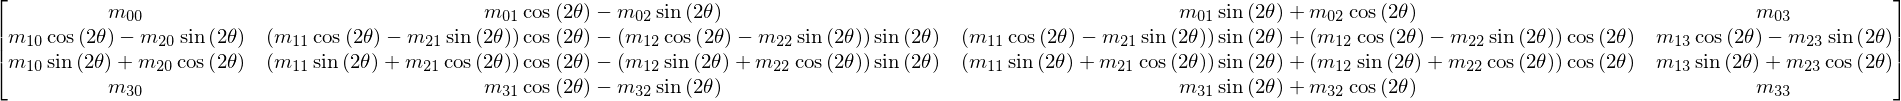

In [319]:
MuellerMatrixRotationSymbol(-theta) * mm_full * MuellerMatrixRotationSymbol(theta)

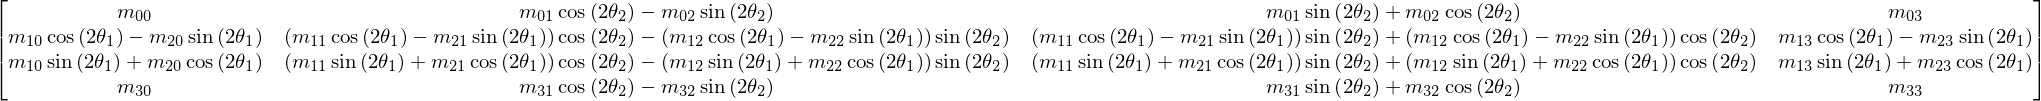

In [336]:
theta1, theta2 = sym.symbols("theta1, theta2")
MuellerMatrixRotationSymbol(-theta1) * mm_full * MuellerMatrixRotationSymbol(theta2)

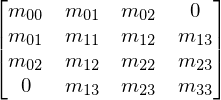

In [337]:
mm_sym = sym.Matrix([
    [m00, m01, m02, 0],
    [m01, m11, m12, m13],
    [m02, m12, m22, m23],
    [0, m13, m23, m33]
])
mm_sym

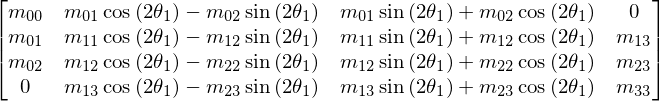

In [339]:
mm_sym * MuellerMatrixRotationSymbol(theta1)

image rotator as three pieces of mirror

In [497]:
p1, p2, p3, d1, d2, d3 = sym.symbols("p1, p2, p3, delta1, delta2, delta3")

In [499]:
mirror1 = sym.Matrix([
            [1, p1, 0, 0],
            [p1, 1, 0, 0],
            [0, 0, -sym.sqrt(1-p1*p1)*sym.cos(d1), -sym.sqrt(1-p1*p1)*sym.sin(d1)],
            [0, 0, +sym.sqrt(1-p1*p1)*sym.sin(d1), -sym.sqrt(1-p1*p1)*sym.cos(d1)]
        ])
mirror2 = sym.Matrix([
            [1, p2, 0, 0],
            [p2, 1, 0, 0],
            [0, 0, -sym.sqrt(1-p2*p2)*sym.cos(d2), -sym.sqrt(1-p2*p2)*sym.sin(d2)],
            [0, 0, +sym.sqrt(1-p2*p2)*sym.sin(d2), -sym.sqrt(1-p2*p2)*sym.cos(d2)]
        ])
mirror3 = sym.Matrix([
            [1, p3, 0, 0],
            [p3, 1, 0, 0],
            [0, 0, -sym.sqrt(1-p3*p3)*sym.cos(d3), -sym.sqrt(1-p3*p3)*sym.sin(d3)],
            [0, 0, +sym.sqrt(1-p3*p3)*sym.sin(d3), -sym.sqrt(1-p3*p3)*sym.cos(d3)]
        ])

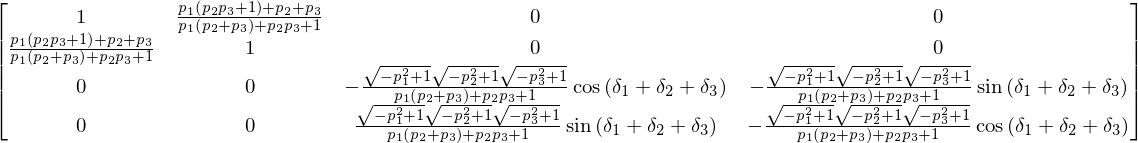

In [503]:
imageRotator =  mirror3 * mirror2 * mirror1
imageRotator = sym.simplify( imageRotator/imageRotator[0,0] )
imageRotator

In [506]:
sym.simplify( imageRotator[2,2]**2 + imageRotator[2,3]**2 + imageRotator[1,0]**2 )

HSP model

In [513]:
m_mir = sym.Matrix([
            [1, p1, 0, 0],
            [p1, 1, 0, 0],
            [0, 0, -sym.sqrt(1-p1*p1)*sym.cos(d1), -sym.sqrt(1-p1*p1)*sym.sin(d1)],
            [0, 0, +sym.sqrt(1-p1*p1)*sym.sin(d1), -sym.sqrt(1-p1*p1)*sym.cos(d1)]
        ])
m_ir = sym.Matrix([
            [1, p2, 0, 0],
            [p2, 1, 0, 0],
            [0, 0, -sym.sqrt(1-p2*p2)*sym.cos(d2), -sym.sqrt(1-p2*p2)*sym.sin(d2)],
            [0, 0, +sym.sqrt(1-p2*p2)*sym.sin(d2), -sym.sqrt(1-p2*p2)*sym.cos(d2)]
        ])
dangle = (-59.4628868-0) * dtor
m_ir = MuellerMatrixRotationSymbol(dangle) * m_ir * MuellerMatrixRotationSymbol(-dangle)
mat = m_mir * MuellerMatrixRotationSymbol(-1.4*dtor)
mat = MuellerMatrixRotationSymbol(90*dtor) @ mat
mat = MuellerMatrixRotationSymbol(-55*dtor) @ m_ir @ mat